<a href="https://colab.research.google.com/github/silprosa/fynesse_mlfc/blob/main/notebooks/Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Socio-Economic and Spatial Determinants of Educational Access and Attainment in Kenya


This project investigates educational access and outcomes using household and individual-level survey data from the Kenyan National Household Survey. The analysis follows the Access-Assess-Address framework.

The research investigates how demographic characteristics, socio-economic conditions, and infrastructure constraints shape educational opportunities across Kenyan communities.

Key areas of focus include analyzing school attendance patterns across different population groups, examining educational attainment levels and their determinants, identifying socio-economic factors that influence educational outcomes, and assessing infrastructure-related barriers that limit access to quality education. The study employs exploratory data analysis to uncover spatial and demographic disparities in educational access, with particular attention to rural-urban differences and household-level predictors of educational success.


### Setup and installation

In [1]:
%%capture
%pip install osmnx

In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import List, Optional

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm


In [4]:
import shutil
shutil.rmtree("/content/fynesse_mlfc", ignore_errors=True)

!git clone https://github.com/silprosa/fynesse_mlfc.git
import os, subprocess, importlib, sys
sys.path.append("/content/fynesse_mlfc")
import fynesse
from fynesse import access, assess, address


Cloning into 'fynesse_mlfc'...
remote: Enumerating objects: 639, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 639 (delta 92), reused 53 (delta 53), pack-reused 529 (from 4)
Receiving objects: 100% (639/639), 12.45 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (364/364), done.


In [5]:
# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Access - Data loading and exploration

In [6]:
access.legal()


'Contains Kenya National Housing Survey 2023/2024 data © National Bureau of Statistics. Kenya National Data Archive (KeNADA).'

In [7]:
household = access.data('/content/drive/MyDrive/knhs/Household_Information_Data.dta')
individual = access.data('/content/drive/MyDrive/knhs/Individual_Data.dta')


DataFrame loaded successfully: 21347 rows, 392 columns
DataFrame loaded successfully: 80889 rows, 97 columns


The analysis utilizes two main datasets: the Household Information Data and Individual Data from the KNHS. The individual dataset contains detailed information about each household member, including education status, while the household dataset provides contextual information about living conditions and infrastructure.


Sorting data by county and household identifiers,

In [8]:
individual = individual.sort_values( by=["a01","interview__key", "hhid__id"],ascending=[True, True,True]).reset_index(drop=True)
individual.iloc[21108:21110,0:20]

,interview__key,interview__id,a01,hhid__id,b02_1,b03,b03_other,b04,b05_years,b05_yrofbirth,b05_monthofbirth,b05_day,age_cur,b06,b07,b08_1,b08_2,b08_3,b08_4,b08_5
21108,22-27-75-72,D2E62F4Beb5A46Dd9Fee86F259928061,Meru,2,Yes,SON OR DAUGHTER,,Male,19,2004.0,DECEMBER,6.0,19.0,NEVER MARRIED,EVANGELICAL CHURCHES,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty
21109,22-27-75-72,D2E62F4Beb5A46Dd9Fee86F259928061,Meru,3,Yes,SON OR DAUGHTER,,Female,16,2007.0,JULY,1.0,16.0,NEVER MARRIED,EVANGELICAL CHURCHES,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty,No - no difficulty


In [9]:
household = household.sort_values(by=["a01","interview__key"], ascending=[True, True] ).reset_index(drop=True)
household.iloc[21107:21110,310:380]

,l07,l08,l09,l10,l11,l12,l13,l14,l15,l16__1,...,l16b__6,l16b__7,l16b__8,l16b__9,l16b__10,l16b__11,l16b__12,l16b__13,min_rent,utilities
21107,NaN,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,1.0
21108,NaN,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,1.0
21109,NaN,2024,NaN,2000.0,No,2001.0,10000000.0,120000000.0,200000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Identifying missing values,

In [10]:
nan_count = household.isna().sum().to_frame().T
display(nan_count)

,interview__key,interview__id,a01,countycode,a07_1,serial,a12,c01_1,c01_1other,c01_2,...,med_prop,med_brms,hhweight,tag,internet,year_occ,pln,sf,duration,bf
0,0,0,0,0,0,0,0,0,0,0,...,15088,16670,0,0,14376,14402,17767,20785,14542,18956


I figured its more convinient working with only columns that I need hence the need to drop the rest.

In [11]:
columns1 = ['b02_1', 'b03_other', 'b05_monthofbirth', 'b05_day', 'age_cur', 'b06', 'b08_1', 'b08_2', 'b08_3', 'b08_4', 'b08_5', 'b08_6', 'b09_1', 'b09_2', 'b09_3', 'b09_4', 'b09_5', 'b09_6', 'b09_7', 'b09_7other', 'b12_other', 'b13_other', 'b13_2_other', 'b13_5', 'b14_1', 'b14_2', 'b14_3', 'b14_4', 'b02_length', 'inw', 'dif_sight', 'dif_hear', 'dif_mobi', 'dif_conc', 'dif_care', 'dif_comm', 'dsb_details', 'dsb_aggregate', 'dsb_aggregate_un', 'diff_sight', 'diff_hear', 'diff_walk', 'diff_rem', 'diff_self_care', 'diff_comm', 'diff_sight_any', 'diff_hear_any', 'diff_walk_any', 'diff_rem_any', 'diff_self_care_any', 'diff_comm_any', 'any_disability', 'disability_d', 'disability_status_unique', 'dis_age', 'dis_age_5yrbands', 'hhh_sex', 'dummy', 'resid', 'sex', 'age_cat', 'age_cat_5yrbands', 'age_cat_10yrbands', 'age_cat_aggregate', 'wap_1', 'age_cohort', 'youth_age', 'youth_age_k', 'agey', 'ken_edu_isced11', 'ken_edu_attendance', 'birthplace', 'relationship_details', 'mrts_details', 'age_dep', 'hhsize', 'size', 'wap', 'age_group']

In [12]:
columns2 = access.get_columns(household)
print(columns2)

['interview__key', 'interview__id', 'a01', 'countycode', 'a07_1', 'serial', 'a12', 'c01_1', 'c01_1other', 'c01_2', 'c01_2other', 'c01_3', 'c01_4', 'c01_5', 'c02_1', 'c02_1other', 'c02_2', 'c02_2other', 'c02_3', 'c02_4', 'c02_5', 'c03', 'c03_other', 'c04', 'c04other', 'c05', 'c06', 'c07', 'c07_1', 'c08', 'c09__1', 'c09__2', 'c09__3', 'c09__4', 'c09__5', 'c09__6', 'c09__7', 'c09__96', 'c09_other', 'c10', 'c10_1', 'c10_2', 'c10_3', 'c10_4', 'c11', 'c11_other', 'c11_1', 'c11_2', 'c11_2_1', 'c11_3', 'c11_4__1', 'c11_4__2', 'c11_4__3', 'c11_4__4', 'c11_4__5', 'c11_4__6', 'c11_4__7', 'c11_4__98', 'c12', 'c12_other', 'c12_1', 'c12_1_1', 'c12_2', 'c12_3', 'c12_3_1', 'c12_4', 'c13__1', 'c13__2', 'c13__3', 'c13__4', 'c13__5', 'c13__6', 'c13__7', 'c13__96', 'c13_other', 'c14_1', 'c14_2', 'c14_3', 'd01', 'd17', 'd18__1', 'd18__2', 'd18__3', 'd18__4', 'd18__5', 'd18__6', 'd18__7', 'd18__8', 'd19', 'd20__1', 'd20__2', 'd20__3', 'd20__4', 'd20__5', 'd20__6', 'd20__7', 'd20__8', 'd20__9', 'd20__10', 'e

We create a copy of the original DataFrame individual and store it as individuals to preserve the raw dataset. In this copy, we rename several columns to more descriptive names for easier interpretation and analysis.i.e b05_years to age, so that the dataset is more readable.

In [13]:
individuals = individual.copy()
individuals.drop(columns=columns1, inplace=True)
individuals.rename(
    columns={
        "interview__key": "interview_key",
        "interview__id": "interview_id",
        "a01": "county",
        "b03": "relationship_to_head",
        "hhid__id": "hh_id",
        "b04": "gender",
        "b05_years": "age",
        "b05_yrofbirth": "yrofbirth",
        "b10": "ever_schooled",
        "b11": "currently_schooling",
        "b12": "current_level",
        "b13": "highest_level",
        "edu_attendance": "education_level",
        "b13_1": "distance_to_school",
        "b13_2": "mode_transport_to_school",
        "b13_3": "time_to_school",
        "b07":   "faith",
        "b13_4": "cost_to_school"
    },
    inplace=True
)

individuals.head(1)

,interview_key,interview_id,county,hh_id,relationship_to_head,gender,age,yrofbirth,faith,ever_schooled,currently_schooling,current_level,highest_level,distance_to_school,mode_transport_to_school,time_to_school,cost_to_school,education_level
0,00-37-92-54,5D28564B41834855A4F231A1A7Fb8C2D,Mombasa,1,HEAD,Male,28,1996.0,PROTESTANT,Yes,No,NaN,STANDARD/GRADE 6,NaN,NaN,NaN,NaN,Primary education


do the same for households.

In [14]:
households = household.copy()
households.rename(
    columns={ "interview__key": "interview_key",
        "interview__id": "interview_id",
        "a01": "county",
         "a07_1": "rural_urban",
        "c01_1": "water_source",
        "c04": "toilet_type",
        "c08": "has_electricity",
        "c13__1": "fixed_internet",
        "c13__2": "mobile_internet",
        "e06": "flooding",
        "g01a": "dist_pri_school",
        "g01b": "dist_sec_school",
        "g02": "units",
        "g04": "has_street_lights",
        "k05": "monthly_rent",
        "k08_1": "rent_increased",
        "k08_2": "no_rent_increase",
        "k08_3": "by_how_much",
        "l14": "dwelling_value"

    },
    inplace=True
)


same thing but different approach

In [15]:
keep_cols = ["interview_key","interview_id","county","rural_urban","water_source","toilet_type","has_electricity","fixed_internet","mobile_internet","flooding","dist_pri_school","dist_sec_school",
    "internet",
    "has_street_lights",

    "monthly_rent",
    "dwelling_value"
]

households = households[keep_cols]


In [16]:
households.head()

,interview_key,interview_id,county,rural_urban,water_source,toilet_type,has_electricity,fixed_internet,mobile_internet,flooding,dist_pri_school,dist_sec_school,internet,has_street_lights,monthly_rent,dwelling_value
0,00-37-92-54,5d28564b41834855a4f231a1a7fb8c2d,Mombasa,Urban,PUBLIC WATER COMPANIES,Flush to PitLatrine,No,0,0,No,2000.0,5000.0,NaN,No,NaN,100000.0
1,00-56-58-97,ff89e29cd1394e5b91d651085e02b363,Mombasa,Urban,PRIVATE WATER COMPANIES,Flush to PitLatrine,No,0,0,No,50.0,5000.0,NaN,Yes,NaN,500000.0
2,00-74-57-01,879340c932cf45edbb6b1c4936db7bbb,Mombasa,Urban,PRIVATE WATER COMPANIES,Flush to Septic tank,Yes,0,1,No,500.0,700.0,1.0,Yes,2000.0,NaN
3,00-94-33-12,687aae7e339749d4bef18a1d2a5c7e93,Mombasa,Urban,PUBLIC WATER COMPANIES,Flush to Septic tank,No,0,1,"Yes, Severe",200.0,200.0,1.0,No,NaN,250000.0
4,01-04-93-27,8a27e6978db34fb9a485f69155c78d4c,Mombasa,Urban,TUBE WELL OR BOREHOLE (Community),Pit latrine with slab,Yes,0,0,"Yes, Mild",2000.0,3000.0,NaN,Yes,2500.0,NaN


the number of missing values is displayed , this will be insightful later.

In [17]:
nan_count = individuals.isna().sum().to_frame().T
display(nan_count)

,interview_key,interview_id,county,hh_id,relationship_to_head,gender,age,yrofbirth,faith,ever_schooled,currently_schooling,current_level,highest_level,distance_to_school,mode_transport_to_school,time_to_school,cost_to_school,education_level
0,0,0,0,0,0,0,0,8,0,5734,17021,51849,17508,51854,58189,57724,76557,0


In [18]:
nan_count = households.isna().sum().to_frame().T
display(nan_count)

,interview_key,interview_id,county,rural_urban,water_source,toilet_type,has_electricity,fixed_internet,mobile_internet,flooding,dist_pri_school,dist_sec_school,internet,has_street_lights,monthly_rent,dwelling_value
0,0,0,0,0,0,0,0,0,0,1,7,8,14376,4,14415,8201


In [19]:
#households['water_source'].value_counts(dropna=False)

# 2: Assess - Data Quality Assessment

The education-related variables of focus include:if a person has ever attended school, current education level, highest education attained, distance to school, transportation modes.

I created a relation table to show the level of education.

In [20]:
education_map = access.education_mapping

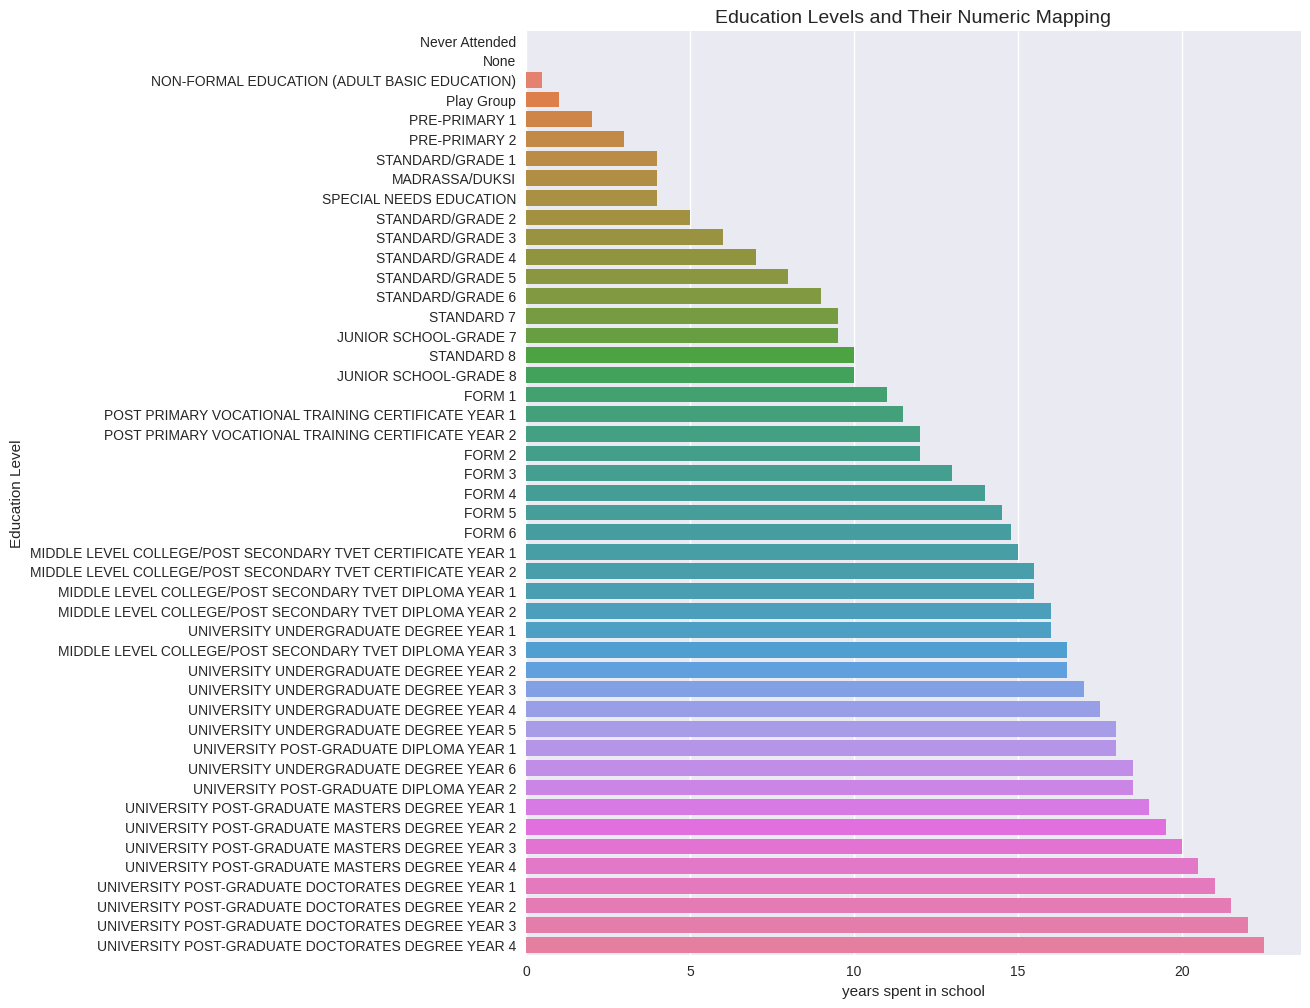

In [21]:

edu_df = pd.DataFrame(list(education_map.items()), columns=["education_level", "mapped_value"])

edu_df = edu_df.sort_values("mapped_value")
plt.figure(figsize=(10, 12))
sns.barplot(x='mapped_value', y='education_level', hue='education_level', data=edu_df,legend=False)
plt.title("Education Levels and Their Numeric Mapping", fontsize=14)
plt.xlabel("years spent in school")
plt.ylabel("Education Level")
plt.show()


In [22]:
simple_education_map = access.easy_education_mapping
print(simple_education_map)

{'Never Attended': 0, 'None': 0, 'NON-FORMAL EDUCATION (ADULT BASIC EDUCATION)': 0, 'Play Group': 1, 'PRE-PRIMARY 1': 1, 'PRE-PRIMARY 2': 1, 'STANDARD/GRADE 1': 2, 'STANDARD/GRADE 2': 2, 'STANDARD/GRADE 3': 2, 'STANDARD/GRADE 4': 2, 'STANDARD/GRADE 5': 2, 'STANDARD/GRADE 6': 2, 'STANDARD 7': 2, 'STANDARD 8': 2, 'JUNIOR SCHOOL-GRADE 7': 2, 'JUNIOR SCHOOL-GRADE 8': 2, 'FORM 1': 3, 'FORM 2': 3, 'FORM 3': 3, 'FORM 4': 3, 'FORM 5': 3, 'FORM 6': 3, 'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 1': 3, 'POST PRIMARY VOCATIONAL TRAINING CERTIFICATE YEAR 2': 3, 'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 1': 4, 'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET CERTIFICATE YEAR 2': 4, 'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 1': 4, 'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 2': 4, 'MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLOMA YEAR 3': 4, 'UNIVERSITY UNDERGRADUATE DEGREE YEAR 1': 5, 'UNIVERSITY UNDERGRADUATE DEGREE YEAR 2': 5, 'UNIVERSITY UNDERGRADUATE DEG

To provide geographical context for our education analysis, we map the counties of Kenya. I inted to plot the map showing average of people if who have ever attended school
First, we extract all the unique counties from the individuals dataset. This gives us the list of counties available in our data.


In [23]:
counties = individuals['county'].unique()

we then clean and standardize county names from the dataset

In [24]:
county_list =access.clean_county_names(counties)
print(county_list)

['Mombasa', 'Kwale', 'Kilifi', 'Tana River', 'Lamu', 'Taita-Taveta', 'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'Tharaka-Nithi', 'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga', 'Muranga', 'Kiambu', 'Turkana', 'West Pokot', 'Samburu', 'Trans Nzoia', 'Uasin Gishu', 'Elgeyo-Marakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma', 'Busia', 'Siaya', 'Kisumu', 'Homabay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi']


I initially used county names direcly to plot counties using omnx function geocoder but it proved to be inconvinient since some county names share names with features such as lakes i.e. turkana ,or names of smaller towns.

Instead of relying on raw text names, we convert county names into their corresponding OpenStreetMap relation IDs.

This is done using the get_relation_ids function, which takes standardized county names and returns unique identifiers recognized by OpenStreetMap.

These identifiers allow us to retrieve accurate county boundaries.

In [25]:
relation_ids = access.get_relation_ids(county_list)
print(relation_ids)

['R3495554', 'R3495548', 'R3495545', 'R3495561', 'R3495550', 'R3495560', 'R3495541', 'R3495566', 'R3495551', 'R3495552', 'R3495542', 'R3495553', 'R3495562', 'R3495540', 'R3495547', 'r3492707', 'r3492708', 'r3495557', 'r3495558', 'r3495546', 'r3977580', 'r3495544', 'R3495564', 'r11981571', 'r3495559', 'r3495563', 'r3495565', 'R11981582', 'R3495556', 'r3495537', 'r3495549', 'r14649082', 'r3338145', 'r3486020', 'r3486288', 'R14649074', 'r3495543', 'r3486322', 'r3495538', 'r3486321', 'r3486291', 'r3486289', 'r3486017', 'r3486018', 'r3338140', 'r3486290', 'R3492709']


Using the relation IDs, we plot the geographical distribution of counties in Kenya with the plot_counties function. This will serve as the base map for visualizing our education analysis across regions.

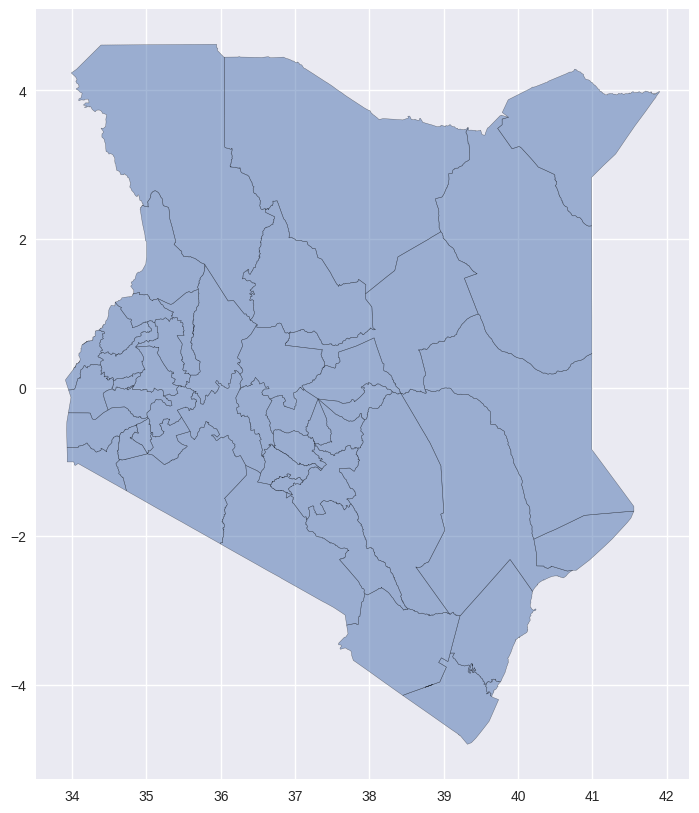

In [26]:
gdf = assess.plot_counties(relation_ids)


We now focus on the ever_schooled column in the individuals dataset, which indicates whether a person has ever attended school.To ensure accuracy in our analysis, i begun by creating a working copy of the dataset and checking for missing values in the ever_schooled column

In [27]:
person  = individuals.copy()
person['ever_schooled'].isna().sum()

np.int64(5734)

Standardize boolean values by using a helper function i.eresponses like "Yes/No" or other variations are converted into consistent True/False values.I also removed missing data related to schooling status.

In [28]:
person = access.clean_boolean_columns(individuals, columns=["ever_schooled"])
person  =person.dropna(subset=['ever_schooled'])
person['ever_schooled'].value_counts(dropna = False)


,count
ever_schooled,
True,63869
False,11286


In [29]:
dist = person.groupby(['county', 'ever_schooled'], observed=True).size().reset_index(name='count')


visualised Distribution of School Attendance Across Counties

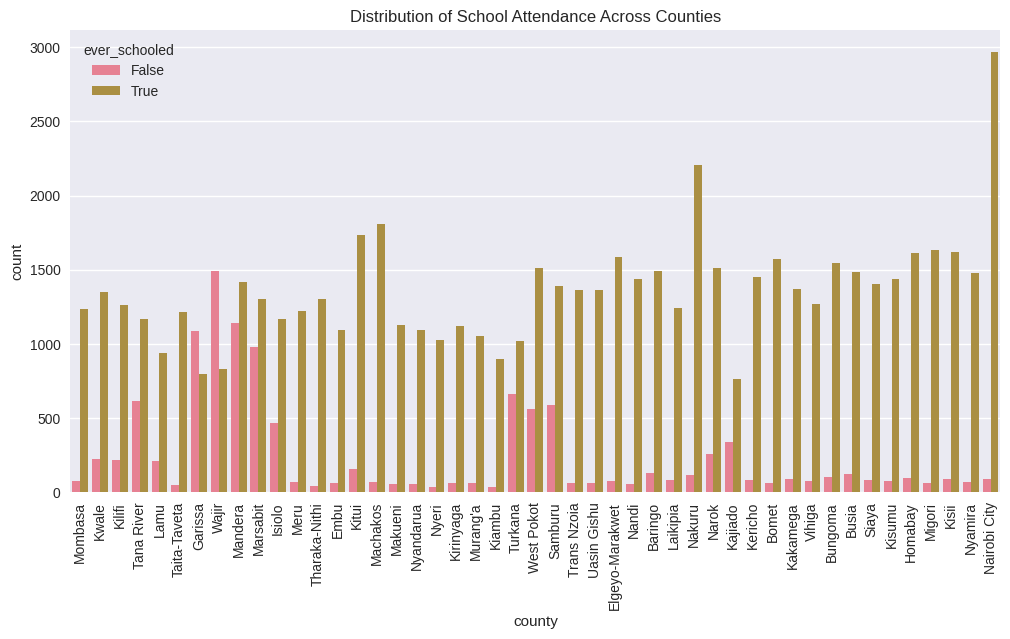

In [30]:
plt.figure(figsize=(12,6))
sns.barplot(data=dist, x='county', y='count', hue='ever_schooled')
plt.xticks(rotation=90)
plt.title("Distribution of School Attendance Across Counties")
plt.show()

To capture regional differences in education, we computed the proportion of individuals who have ever attended school for each county.

In [31]:
mean_schooled = person.groupby('county',observed=False )['ever_schooled'].mean().reset_index(name='mean_prop_schooled')
prop = mean_schooled['mean_prop_schooled'].astype(float)

the generated choropleth map visualizes the geographical distribution of educational access across Kenyan counties,i.e shows the average proportion of individuals who have ever attended school in each region.

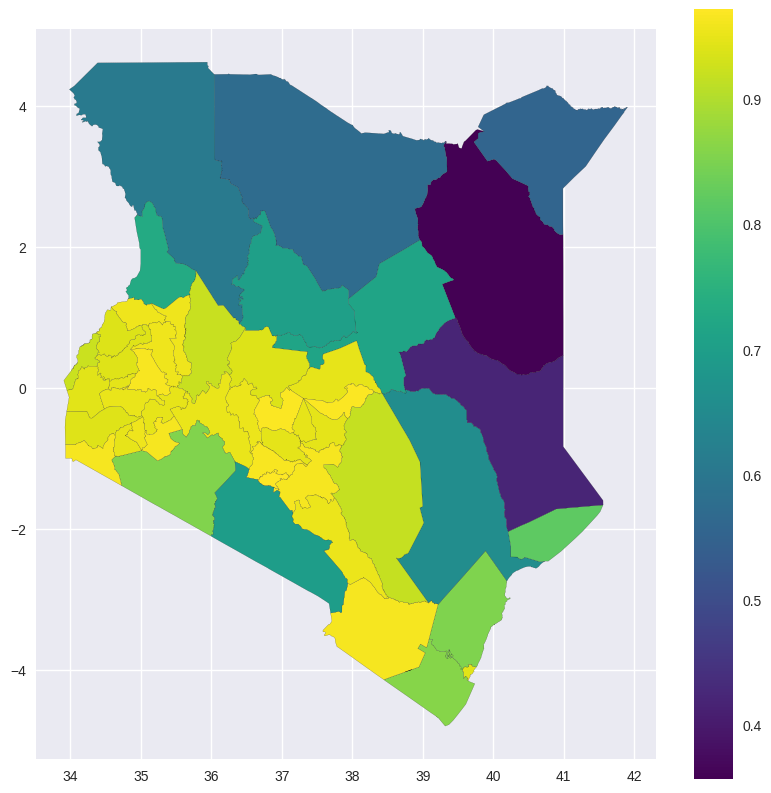

In [32]:
assess.plot_counties(relation_ids, prop)

#plot_counties(relation_ids, prop)

## Internet access

In [33]:
households['internet'].value_counts(dropna=False)

,count
internet,
NaN,14376
1.0,6971


On inspecting the distribution of the internet variable, including missing values. This helps us understand the raw survey responses on whether households reported having internet access. Missing values could represent households that either skipped the question or were not asked.

Since there are only 1 and 0 values, the later could represent a houshold not having internet access but because of uncertainity I will capture them explicitly.




In [34]:
house = households.copy()
house['internet_clean'] = house['internet'].fillna(0).astype(int)


Household internet access was aggregated at the county level. Since the variable is binary, its mean represents the proportion of households with internet access. Converting this value into percentages provides a clearer interpretation.

 This feature shows regional disparities in digital connectivity, with counties showing low penetration likely to experience additional challenges in accessing online educational resources.

In [35]:
county_pct_internet = (
    house.groupby("county", observed = False)["internet_clean"]
    .mean()
    .reset_index(name="county_pct_internet")
)
county_pct_internet["county_pct_internet"] *= 100


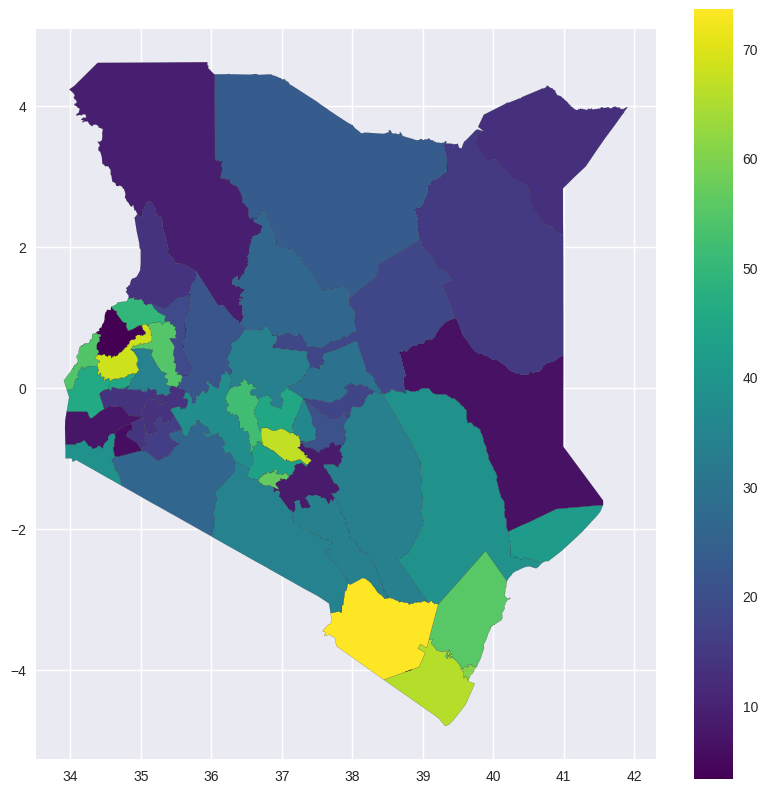

In [36]:
assess.plot_counties(relation_ids,county_pct_internet["county_pct_internet"])

Because of the uncertainity of missing values, its probably not a good idea to use this feature.

### Gender Distribution


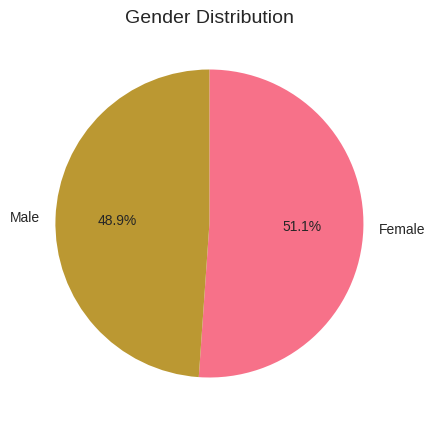

In [37]:
gender_counts = person['gender'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(gender_counts,labels=gender_counts.index,autopct='%1.1f%%',startangle=90,counterclock=False)
plt.title("Gender Distribution", fontsize=14)
plt.show()

This indicates a nearly balanced gender distribution with a slight female majority.

### Education Level Distribution

The bar chart shows the distribution of education levels in the dataset. Most of the individuals have their current highest education level as primary education.

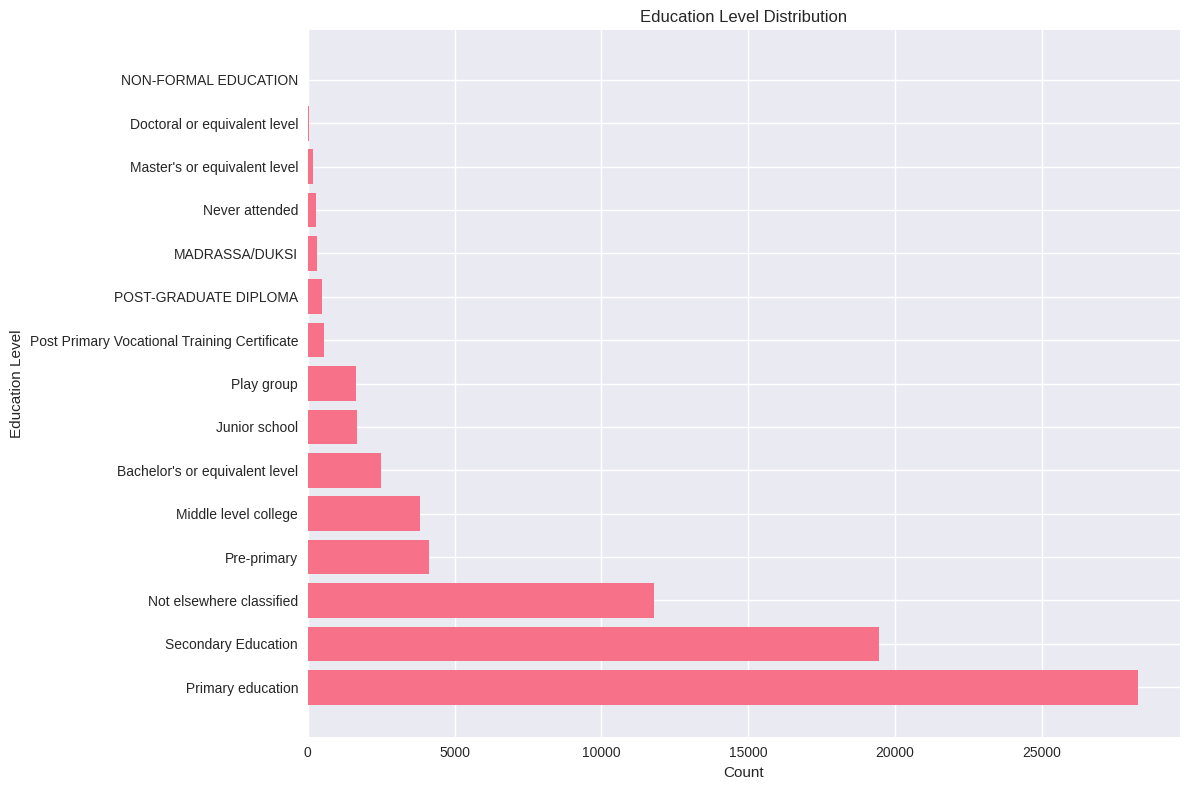

In [38]:
assess.plot_education_levels(person['education_level'])

### Distance to the nearest school from a housholds

The function below analyzes the total values of distances from every household.

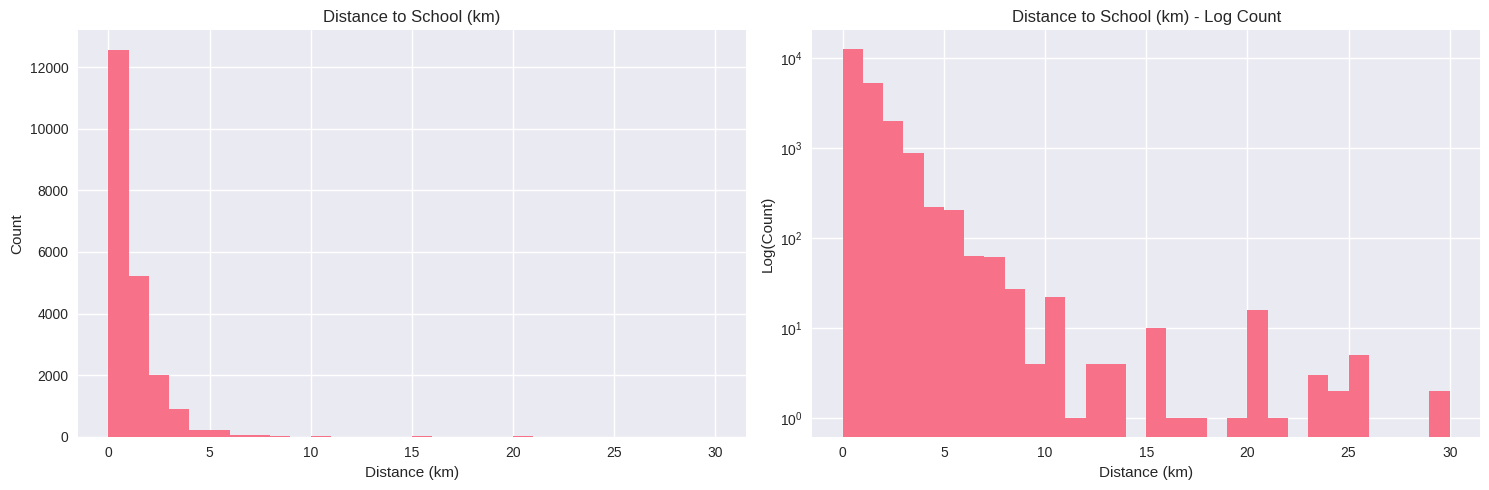

In [39]:
assess.analyze_distance_to_school(households["dist_pri_school"])

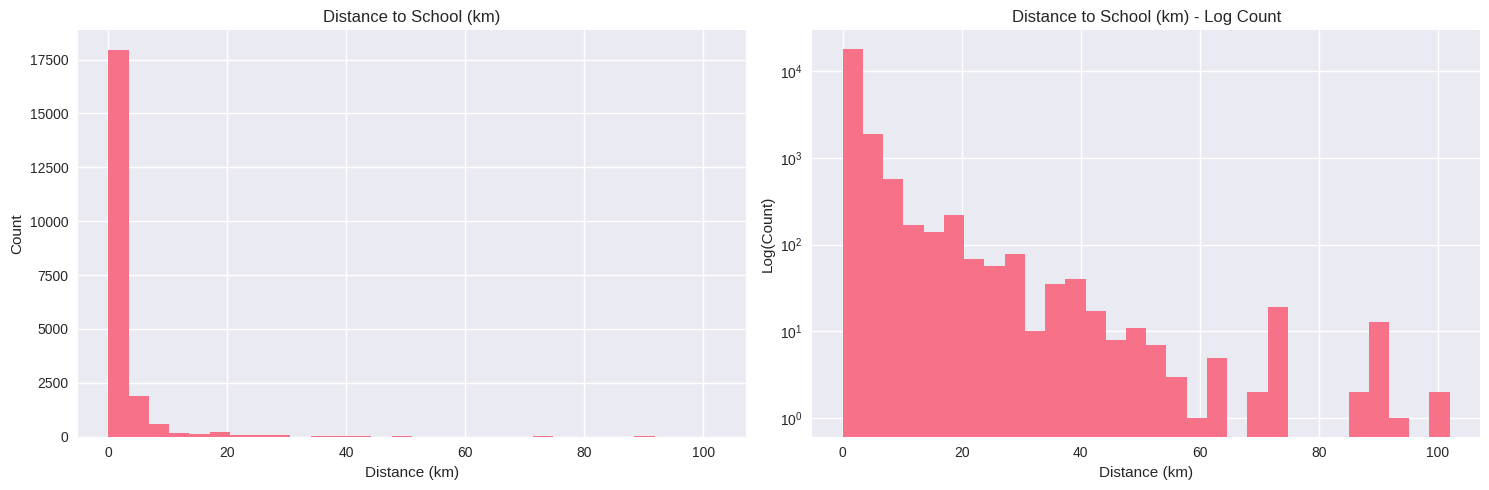

In [40]:
assess.analyze_distance_to_school(households["dist_sec_school"])

The bar chart presents the average distance to primary and secondary schools across counties. Each county is represented along the x-axis, while the y-axis shows mean distance.

This visualization highlights regional variation in school accessibility: counties with higher average distances may face greater barriers to education, particularly for younger learners.

Such disparities are important for understanding geographic inequality in school access and can inform resource allocation or infrastructure planning.

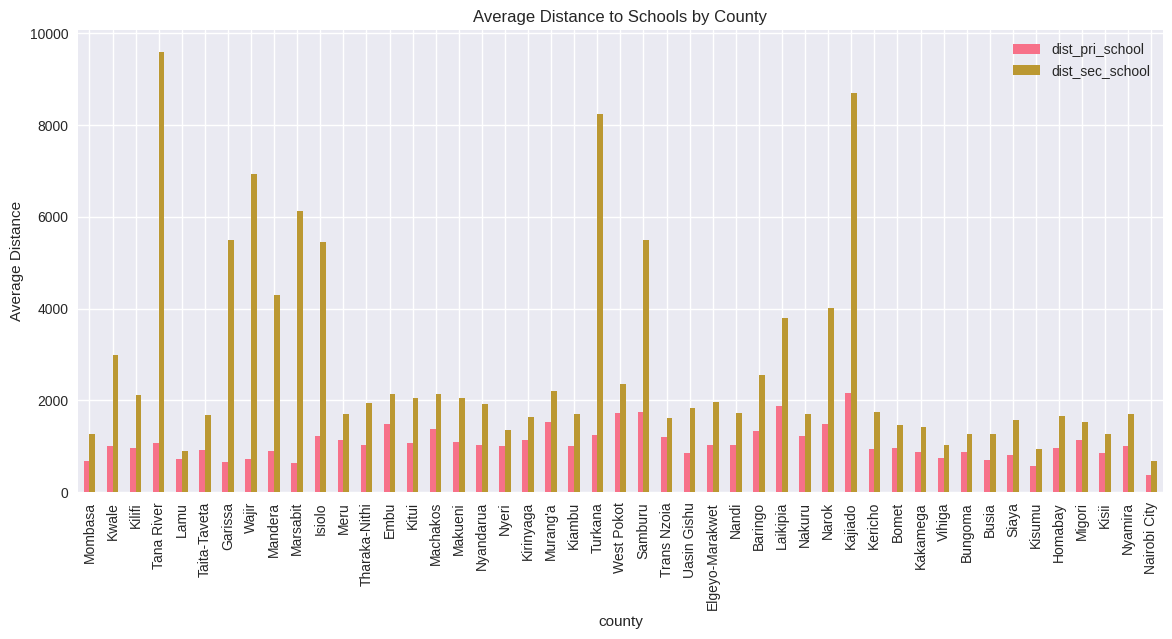

In [41]:
county_distances = (house.groupby("county", observed= True)[["dist_pri_school", "dist_sec_school"]].mean().reset_index())
county_distances.plot( x="county",kind="bar",figsize=(14,6))
plt.ylabel("Average Distance")
plt.title("Average Distance to Schools by County")
plt.xticks(rotation=90)
plt.show()

From the plot above I observed some distances particulally in secondary schools varied differently with counties .I decided to see if there is a relation between distance and the area of a county.

In [42]:
area = access.data("/content/drive/MyDrive/area.csv")

DataFrame loaded successfully: 47 rows, 4 columns


county-level distance data is merged with county area data. Since naming inconsistencies exist across datasets, county names are standardized inside the function.

In [43]:
area = assess.merge_county_data(area, county_distances)
area.head(3)

,No.,county,Area,Density,dist_pri_school,dist_sec_school
0,1,Turkana,98597.8,10.11,1236.104620,8243.937500
1,2,Marsabit,66923.1,7.52,632.778788,6115.400433
2,3,Wajir,55840.6,15.19,721.420722,6938.320251


This function below explores whether the geographic size of a county influences the average distance to schools by plotting county area against mean school distance.A regression trend line indicates whether larger counties tend to have longer travel distances to schools.

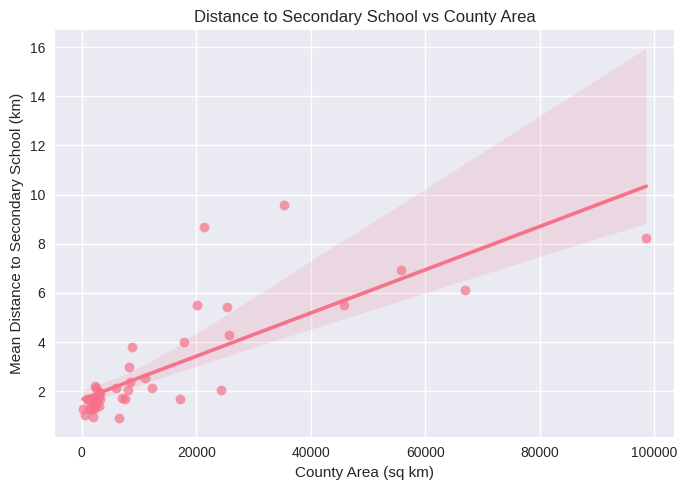

In [44]:
assess.plot_distance_vs_area(area, "dist_sec_school", "Distance to Secondary School")


The relationship between distance of secondary schools and area is a positive slope suggests that larger counties generally have schools located farther from households, which could imply accessibility challenges in sparsely populated regions.

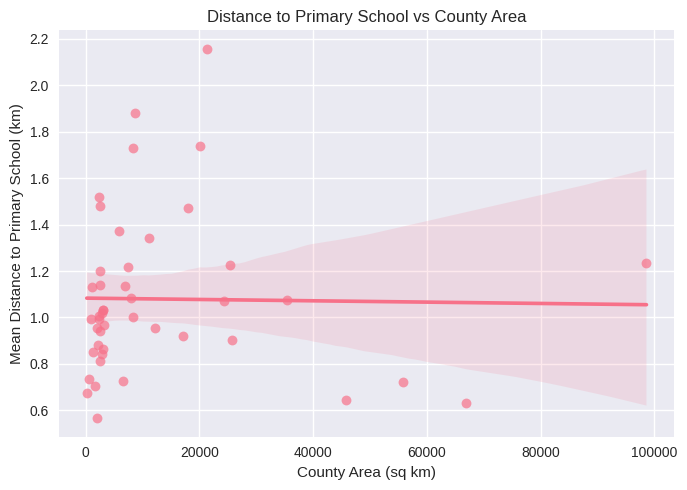

In [45]:
assess.plot_distance_vs_area(area, "dist_pri_school", "Distance to Primary School")


As for primary Schools the relationship is weak relationship indicates that county size alone does not strongly determine school accessibility, suggesting other factors such as population density e.t.c may be more influential.

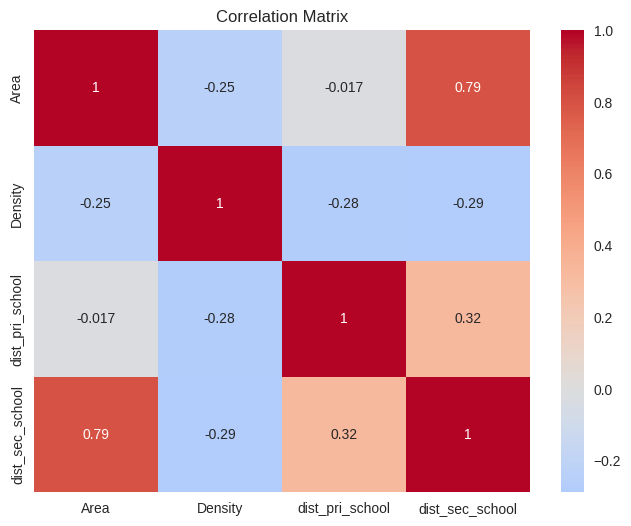

In [46]:
plt.figure(figsize=(8,6))
sns.heatmap(area[["Area", "Density" ,"dist_pri_school", "dist_sec_school"]].corr(),
    annot=True, cmap="coolwarm", center=0
)
plt.title("Correlation Matrix")
plt.show()


Population density has a negative correlation to the distances.

### Parental Influence on Education

Does the parents education level influence the childs education?

To answer this question we can  visualize the correlation between the education of the head of the house and the education of children in that household.

After the education column is cleaned below,the function 'parent_child_education' compiles all children in households and joins the heads'/parents' education levels to each row of the respective child.

In [47]:
person["education_level"] = person["education_level"].str.strip()
result = assess.parent_child_education(person)

We can then plot the relation as

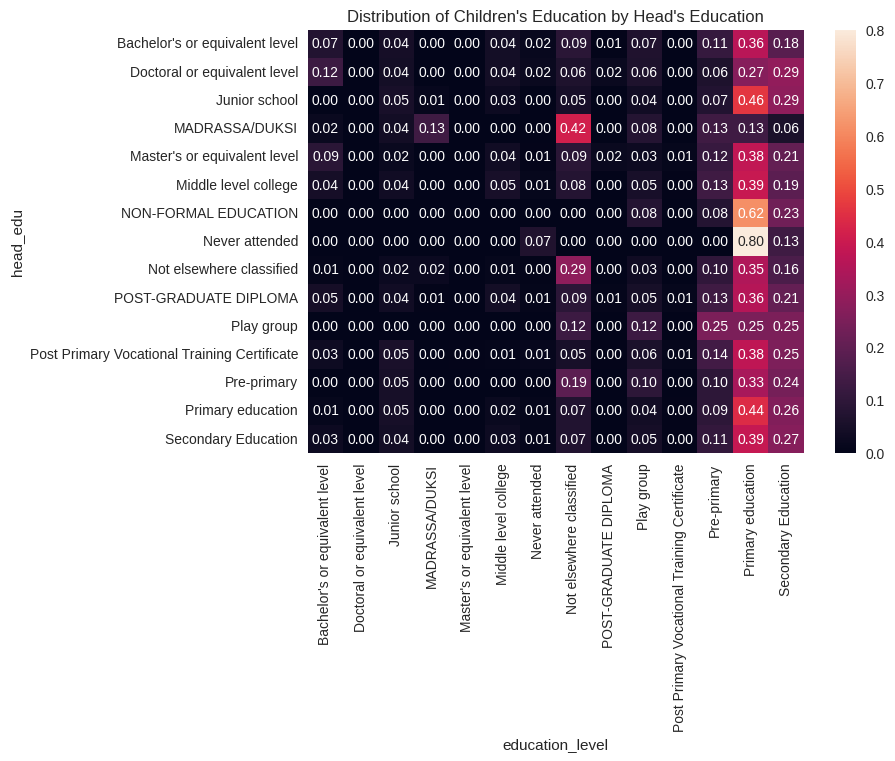

In [48]:
ct = pd.crosstab(result["head_edu"], result["education_level"], normalize="index")
sns.heatmap(ct, annot=True, fmt=".2f")
plt.title("Distribution of Children's Education by Head's Education")
plt.show()

An interesting observation from this is  Household heads who "Never attended" school or have only "Non-formal education" ,their children have very high probabilities of having primary education.

Another observation is those with Bachelor's, Master's, or Doctoral degrees show descent probabilities  of their children reaching similar academic levels.

The data reveals limited upward educational mobility - children from less-educated families rarely achieve significantly higher education levels than their parents.

### Age vs Education Level

An individuals age may strongly influences the person education level. We can visualize the age distribution within each education category, which can reveal whether certain education levels cluster around specific age ranges.

In [49]:
edu_order = person["education_level"].unique().tolist()

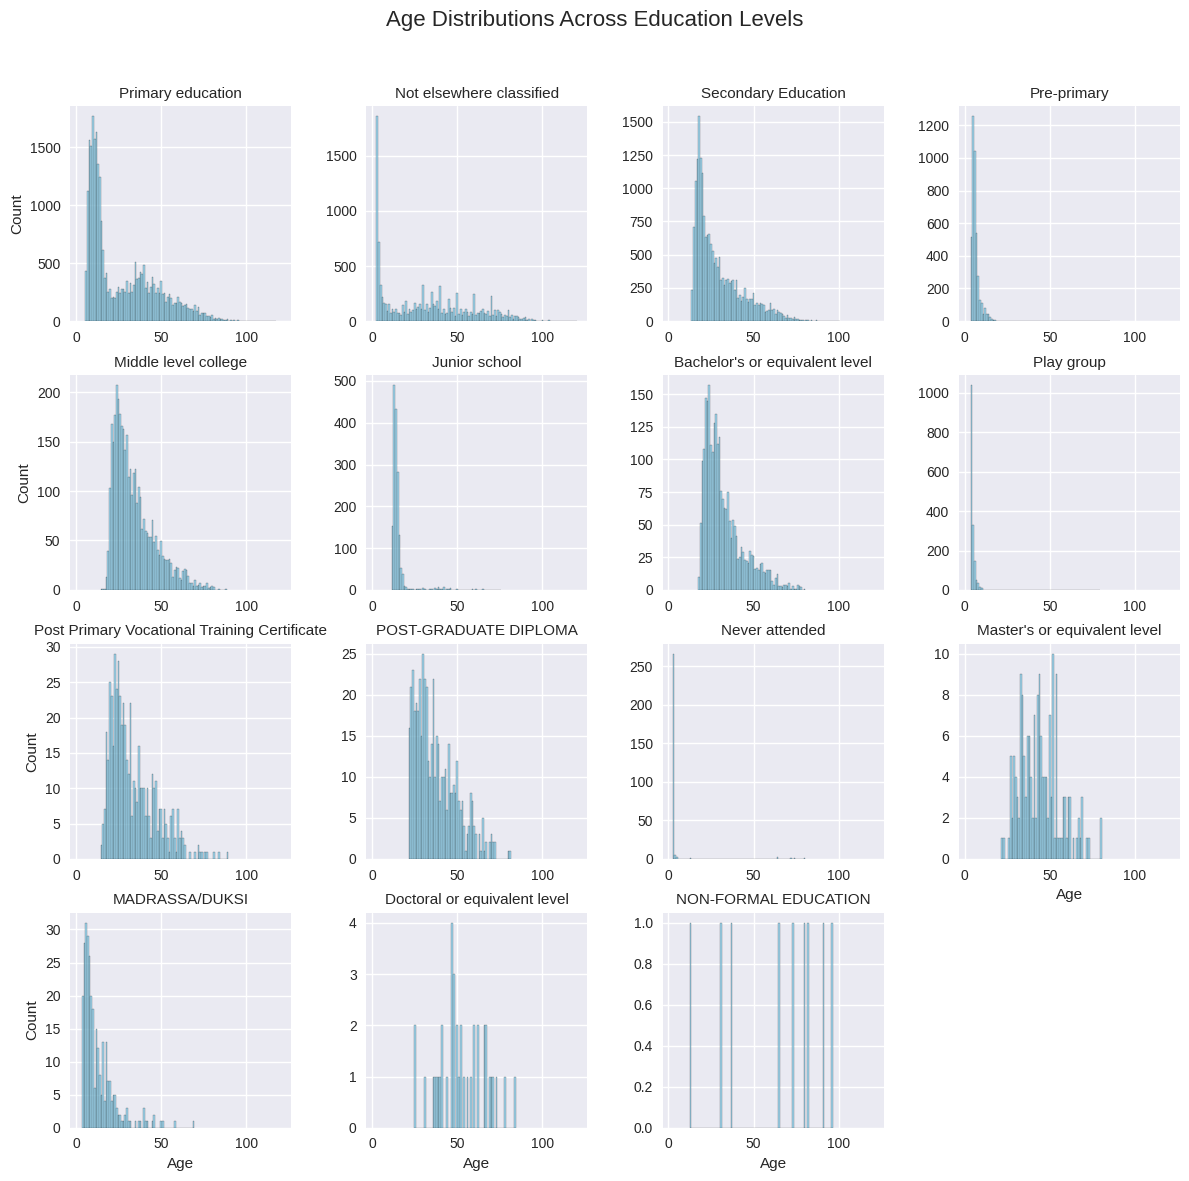

In [50]:
assess.plot_age_distribution_by_education(person, edu_order,
    title="Age Distributions Across Education Levels")


the plots indicate a youth skewed population indicating that  youths have greater oportunity to education than older generations.

 A significant number of those who are not elsewhere classified and never attended are under the age of 5, indicating that they have'nt started school yet.



This shows age is a key indicator of education level.

### Household position

In order to get the relationships available, we get the unique value relationships from the individuals dataset.

In [51]:
relation_list = person['relationship_to_head'].unique().tolist()

This function creates separate countplot visualizations to examine how a variable i.e. education level, is distributed across different relationship types within households.

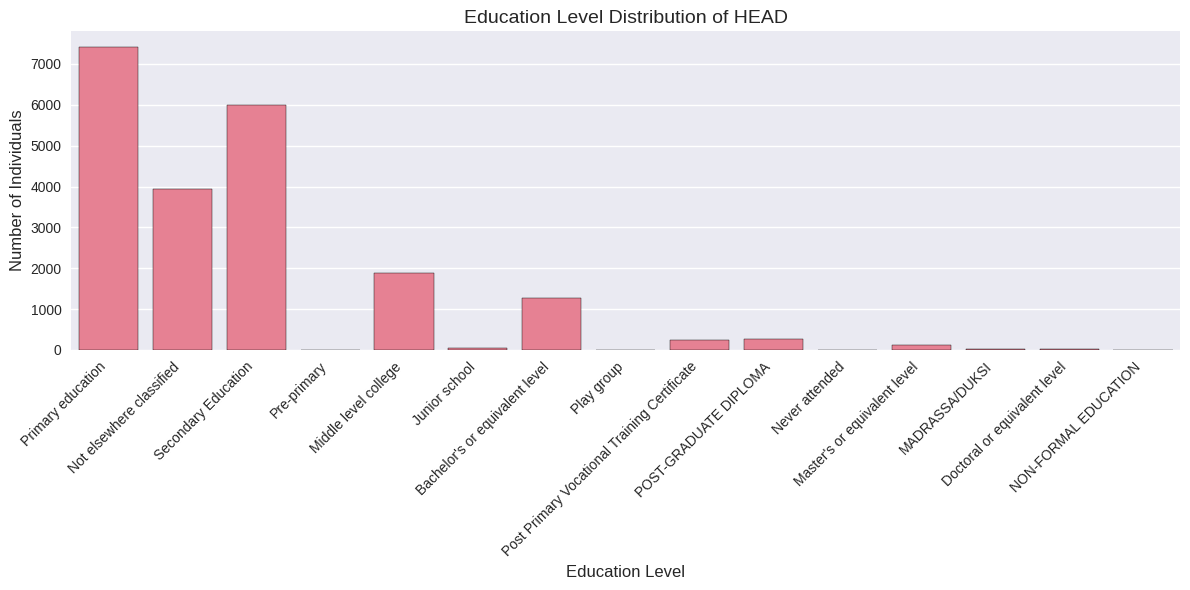

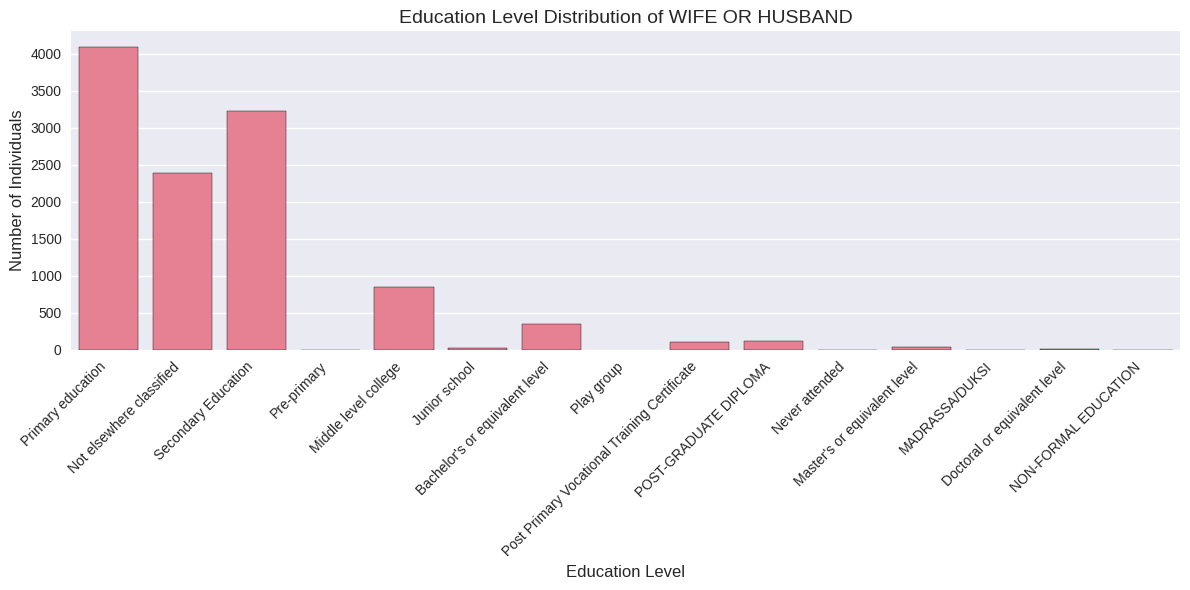

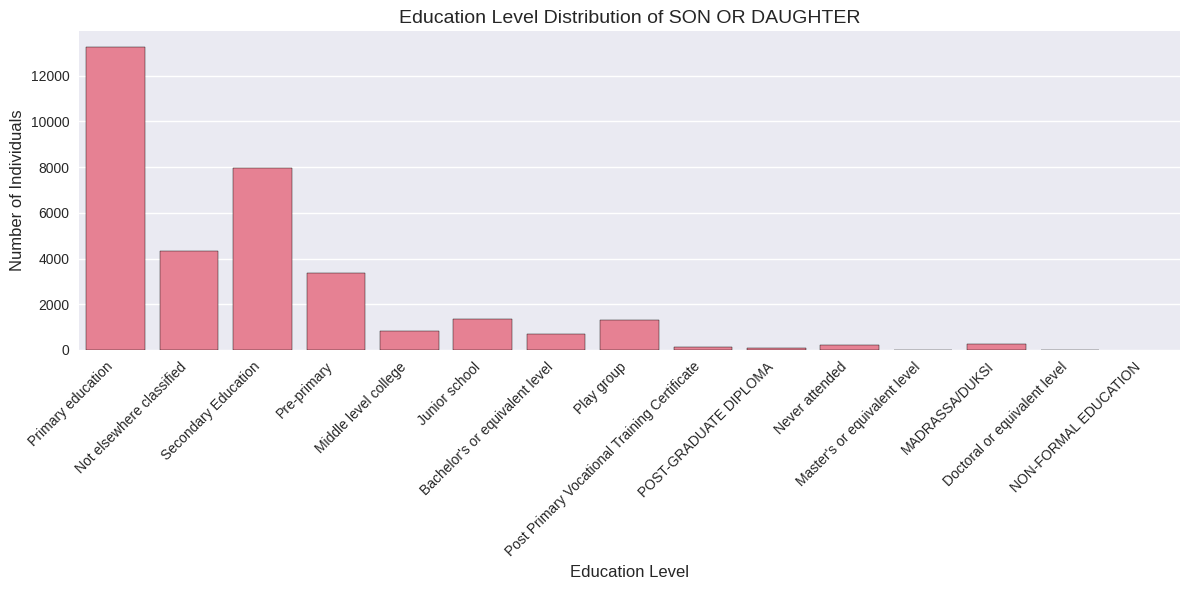

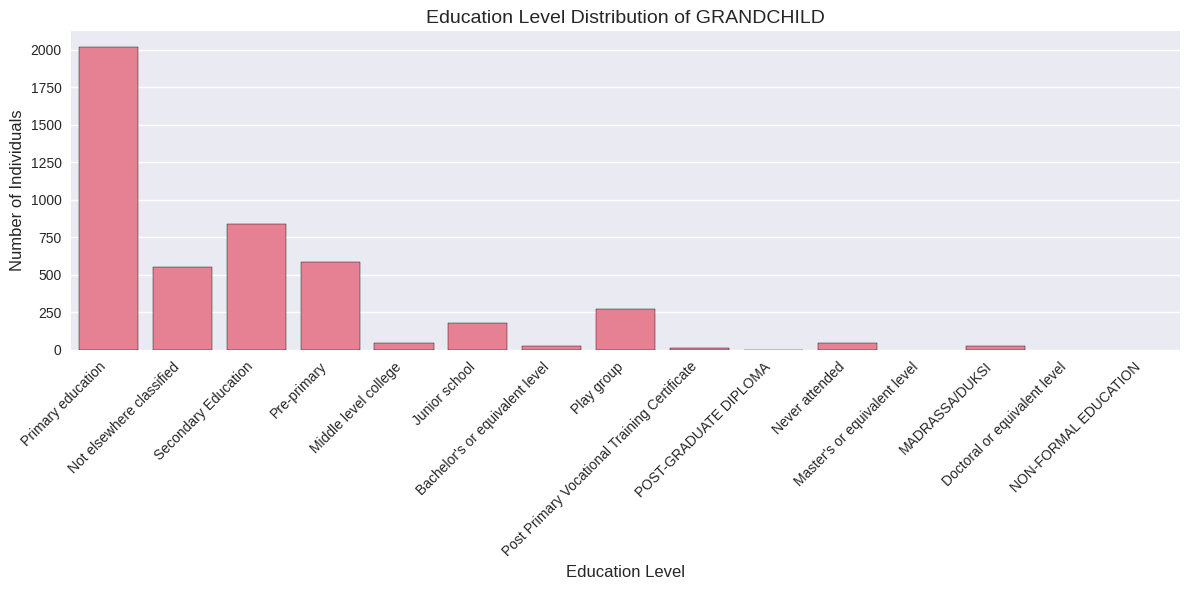

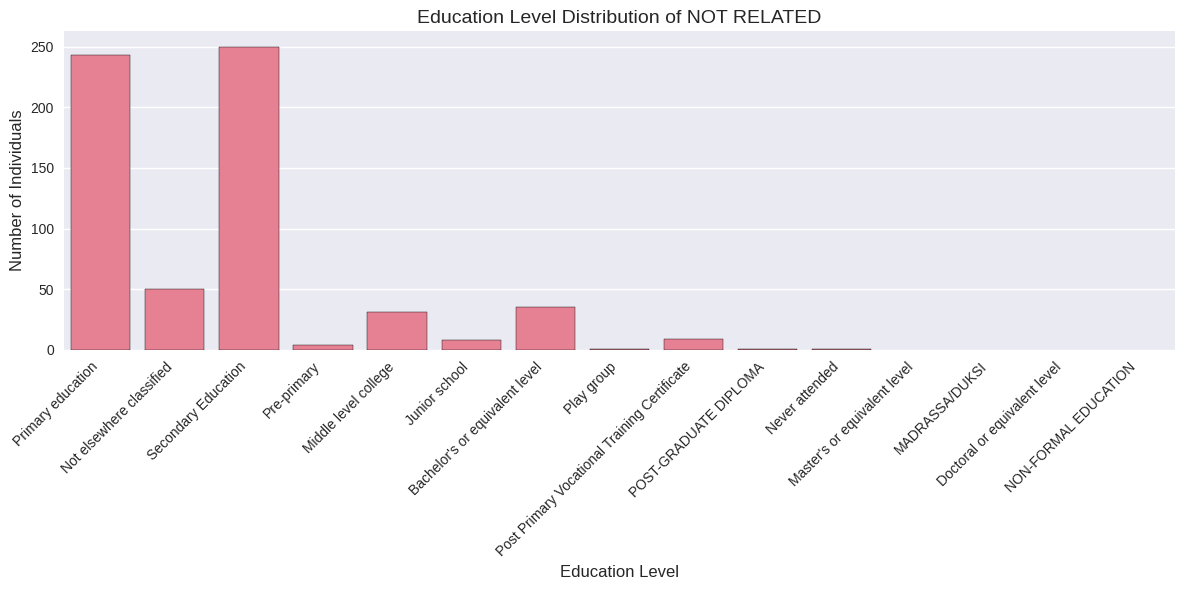

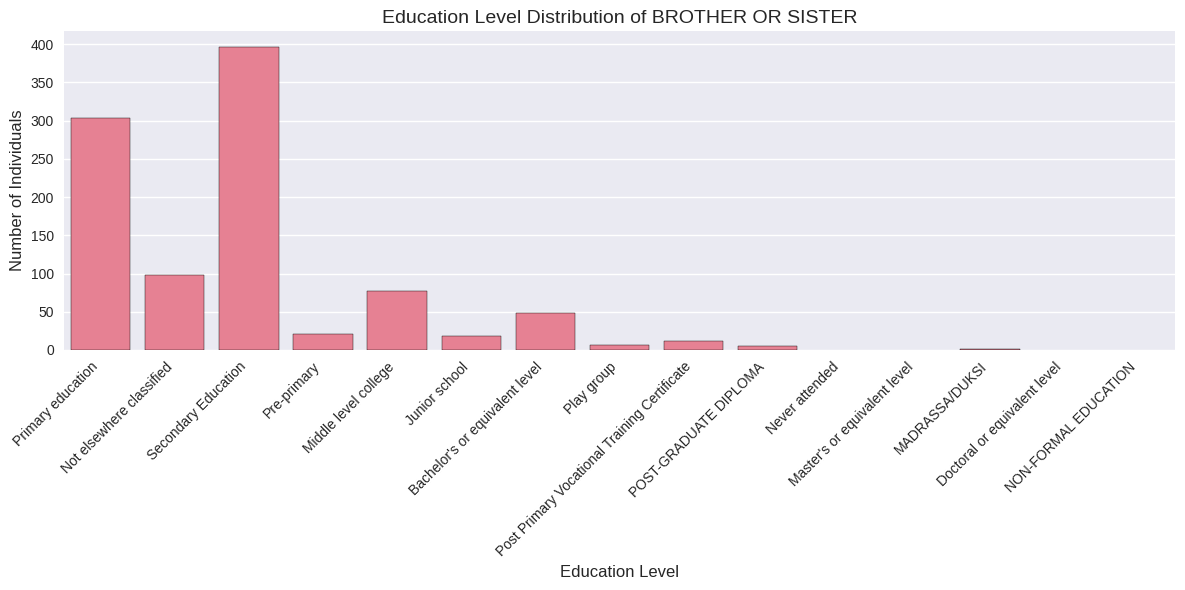

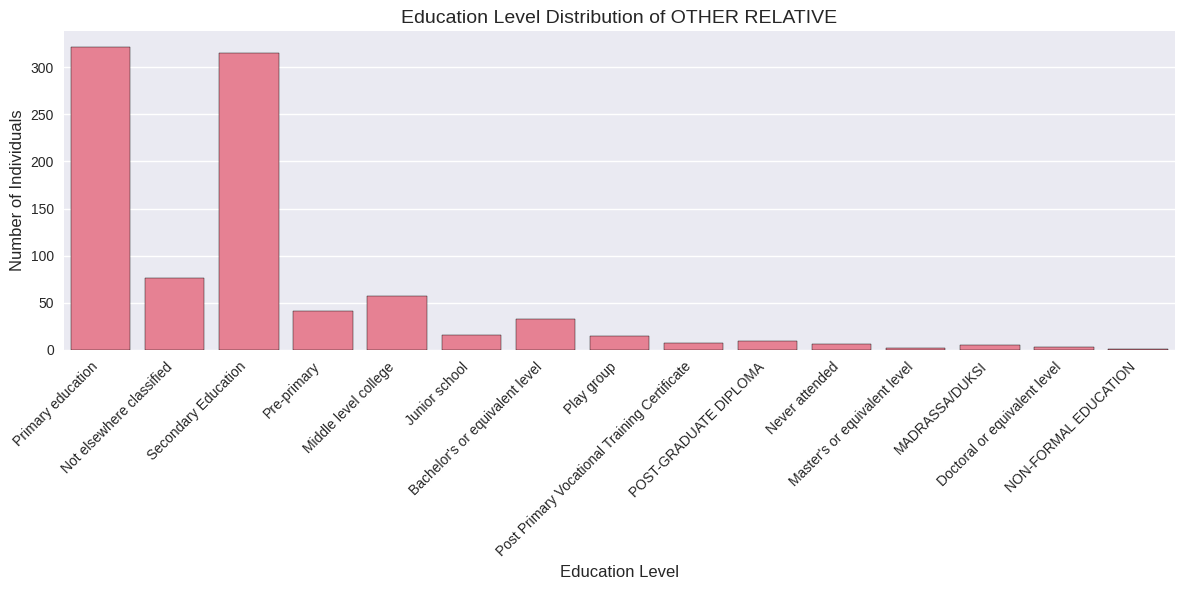

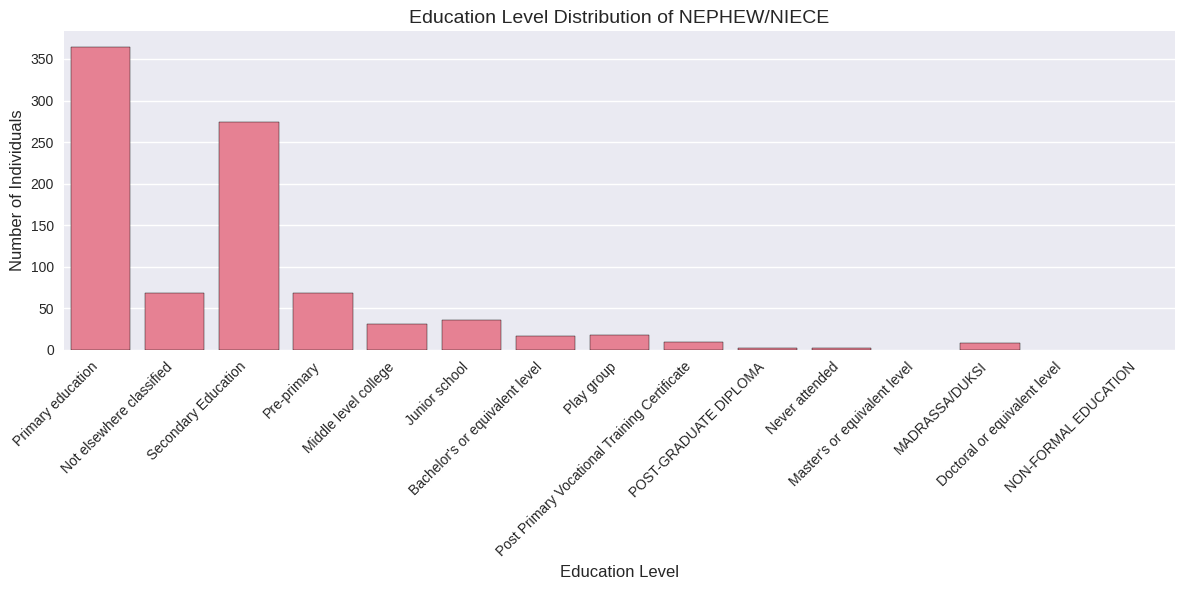

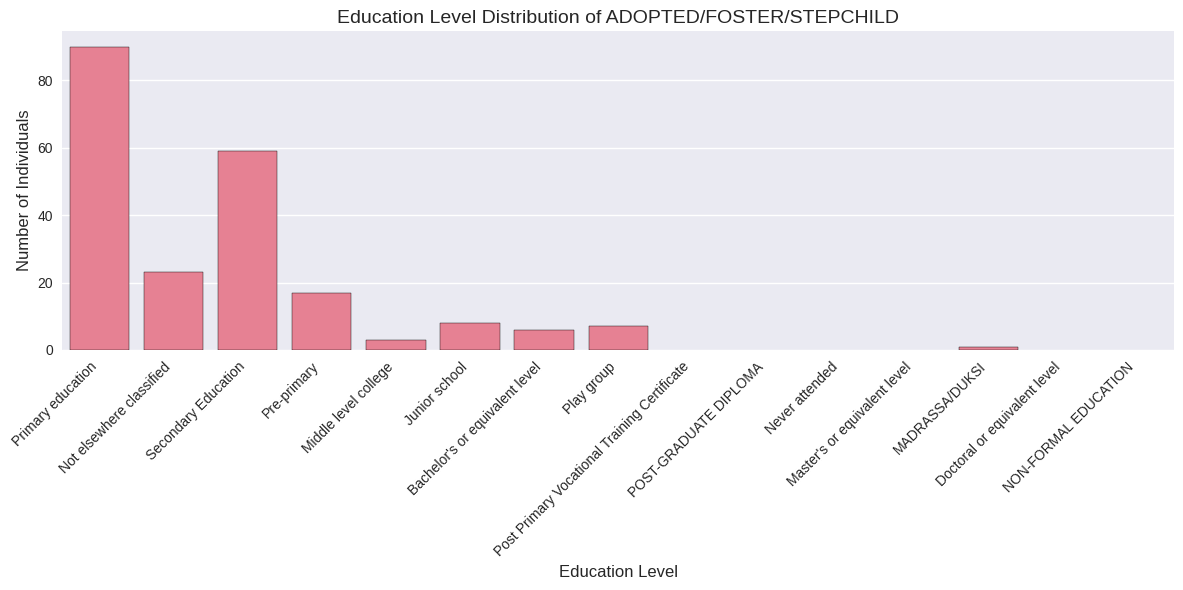

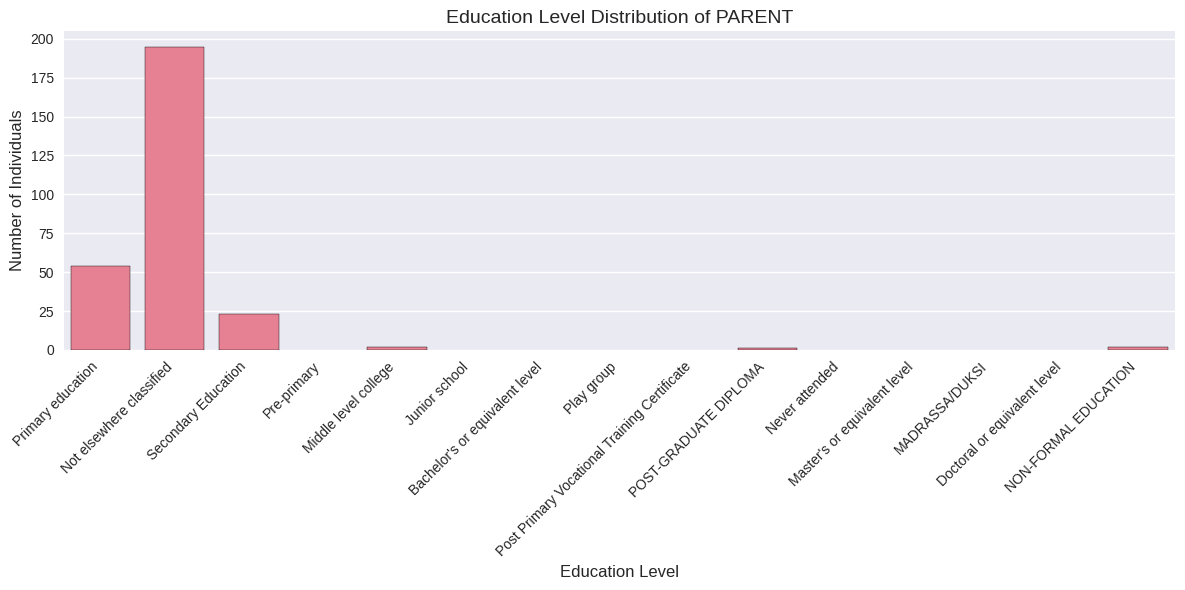

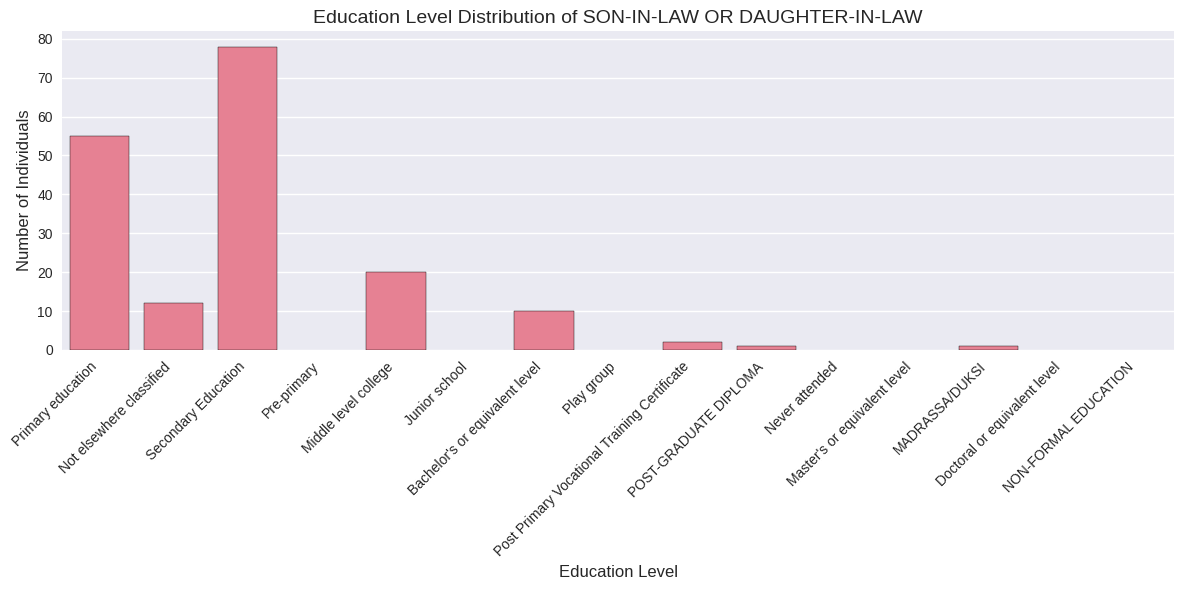

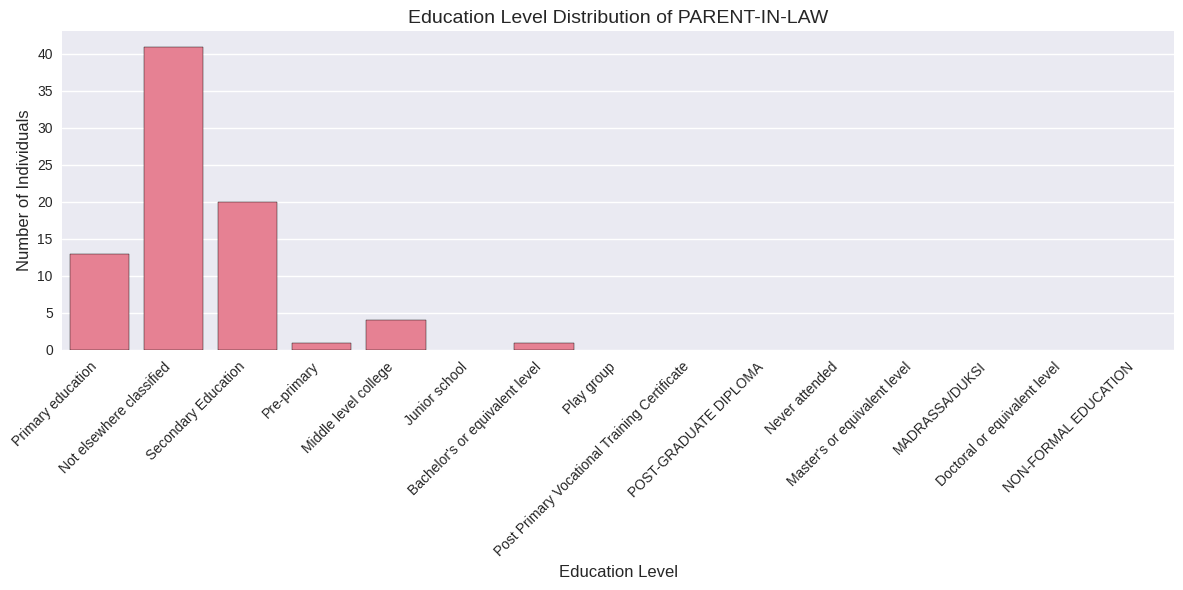

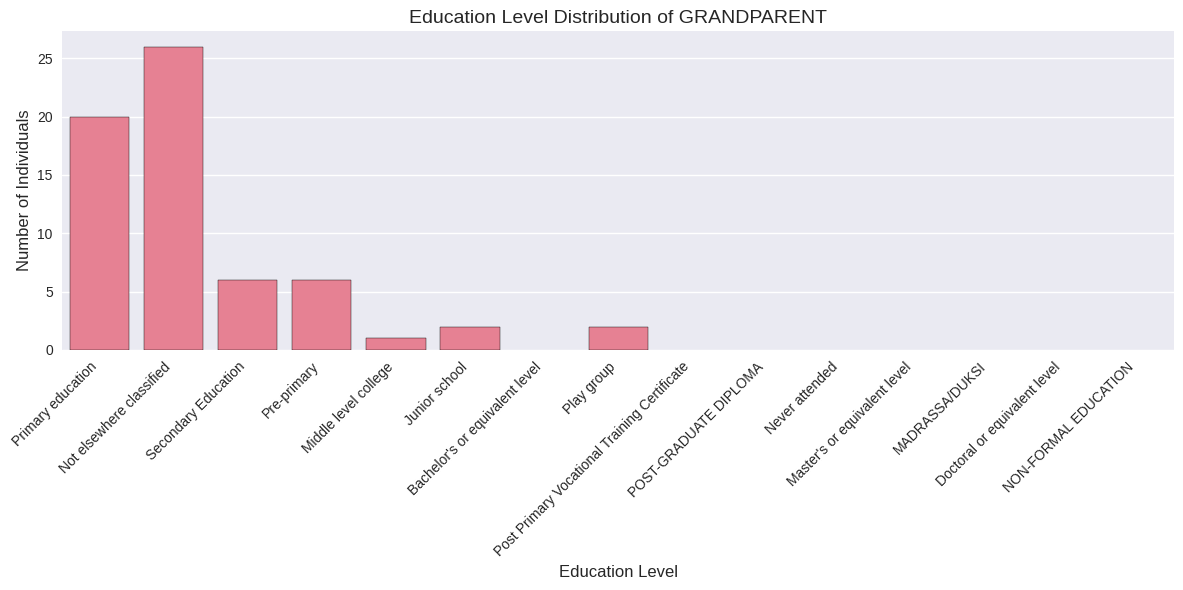

In [52]:
assess.plot_relationships_distribution(person, column="education_level", relationships=relation_list, order=edu_order)


from this we infer that the parents head are most appearing in the 'not elswhere classified' category.
As for the rest of the relations, they appear to be similar.

### House Value
since employment information about individuals is undisclosed due to confidential reasons ,I  opted to use related variable i.e(dwelling value / monthly rent )as the substitute.
### a) Monthly Rent
To utilize this variable , we need to  isolates household heads from the individuals dataset, recognizing that the head's education level is likely the primary driver of household economic decisions, including housing choices.


In [53]:
household_heads = individuals[individuals['relationship_to_head'] == 'HEAD'].copy()

We then join  household heads' education data and household-level information (county and monthly rent), using interview_key as the linking identifier.

In [54]:
house_rent = pd.merge(household_heads[['interview_key', 'education_level']],
                    households[['interview_key','county', 'monthly_rent']],
                    on='interview_key',
                    how='inner')


Since not all houses pay rent we can drop the missing values.

In [55]:
house_rent = house_rent.dropna(subset=['monthly_rent'])

print(f"Household heads: {len(household_heads)}")
print(f"Merged dataframe: {len(house_rent)}")
print(f"Households: {len(households)}")

Household heads: 21286
Merged dataframe: 6913
Households: 21347


We can then plot this information using box plots and using log scale because of outliers in the rent value.

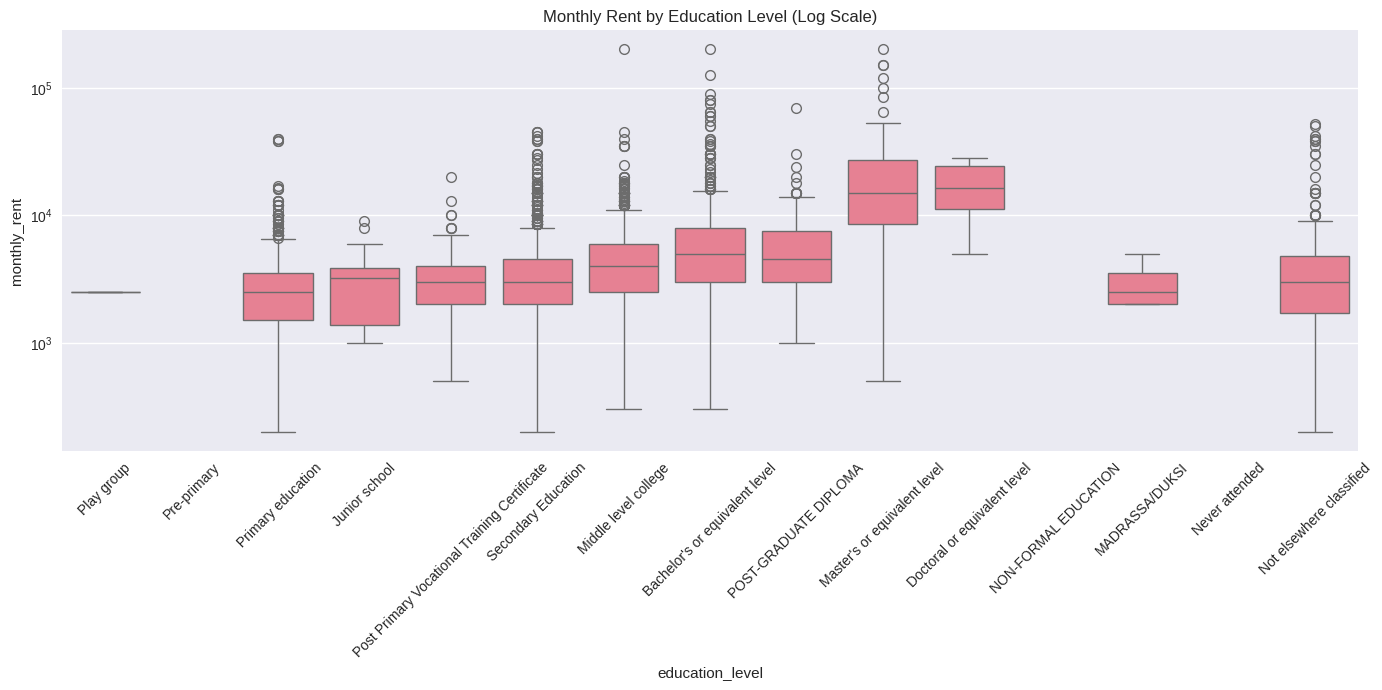

In [56]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=house_rent, x="education_level", y="monthly_rent")
plt.xticks(rotation=45)
plt.yscale('log')  # Use logarithmic scale
plt.title("Monthly Rent by Education Level (Log Scale)")
plt.tight_layout()
plt.show()

There's a distinct upward trend in median rent as education levels increase, with the most jump occurring at higher education levels (Master's, Doctoral). This indicates that higher education translates into significantly better economic outcomes and housing choices.

### b) Dwelling Value
This is for people who actually own the households they live in.
Similar observations holds for dwelling value similar to the ones observed in monthly rent.

Household heads: 21283
Merged dataframe: 13102
Households: 21347


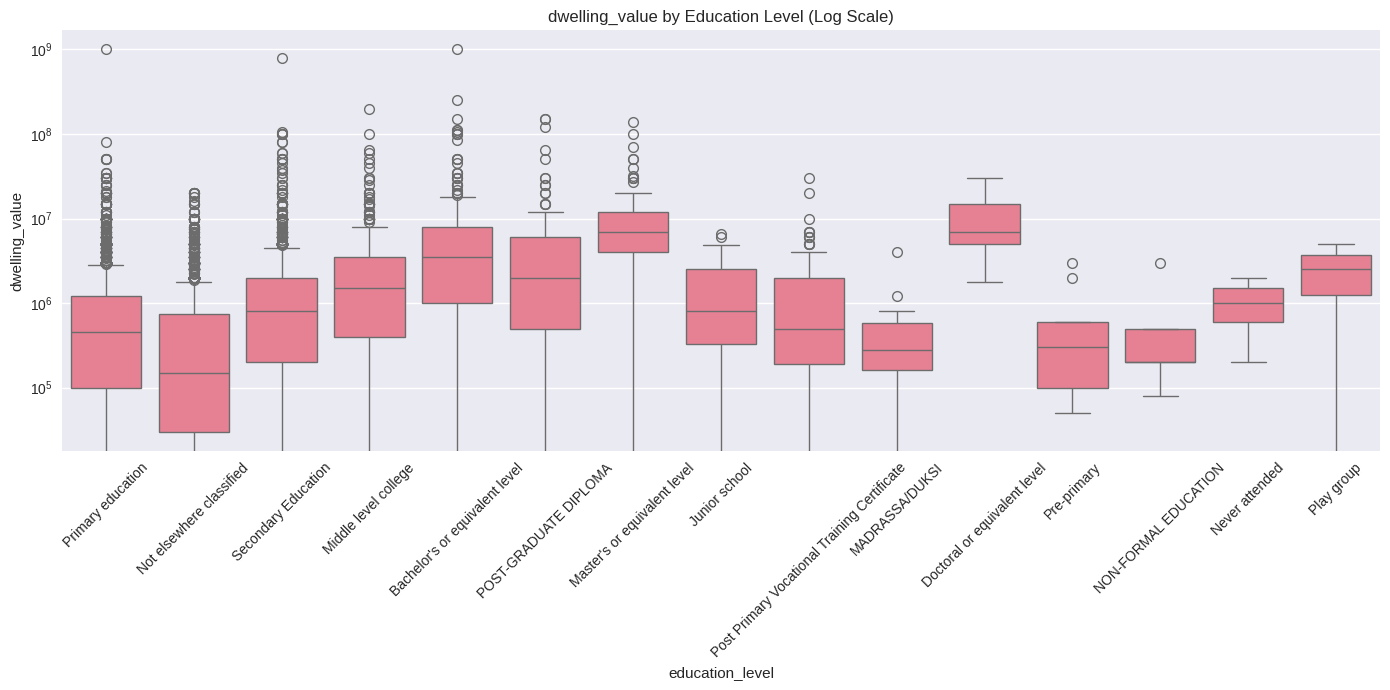

In [57]:
household_heads = person[person['relationship_to_head'] == 'HEAD'].copy()
house_value = pd.merge(household_heads[['interview_key', 'education_level']],
                    house[['interview_key','county', 'dwelling_value']],
                    on='interview_key',
                    how='inner')

house_value = house_value.dropna(subset=['dwelling_value'])
print(f"Household heads: {len(household_heads)}")
print(f"Merged dataframe: {len(house_value)}")
print(f"Households: {len(house)}")

plt.figure(figsize=(14, 7))
sns.boxplot(data=house_value, x="education_level", y="dwelling_value")
plt.xticks(rotation=45)
plt.yscale('log')  # Use logarithmic scale
plt.title("dwelling_value by Education Level (Log Scale)")
plt.tight_layout()
plt.show()

### Electricity & Rural/Urban

We begin by first adding household-level infrastructure and location variables (has_electricity and rural_urban) to the individual-level person dataset.

In [58]:
person = person.merge(
    households[["interview_key", "has_electricity", "rural_urban"]],
    on="interview_key",
    how="left"
)


I then plotted the relationship between electricity and if a person has ever schooled

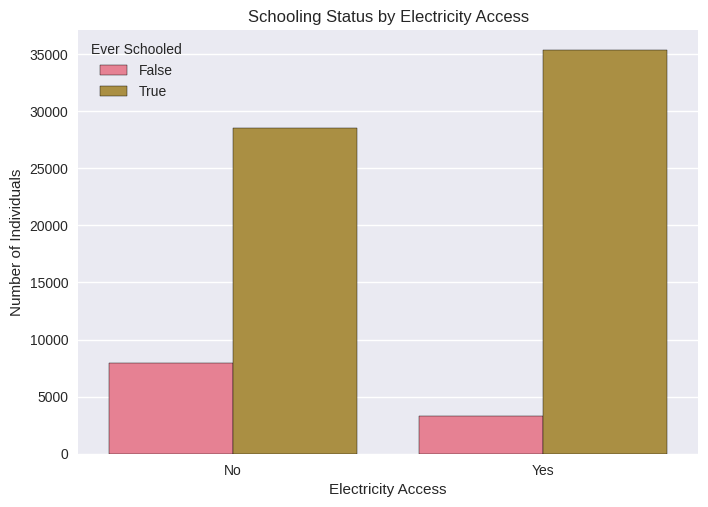

In [59]:
sns.countplot(
    data=person,
    x="has_electricity",
    hue="ever_schooled",
    edgecolor="black"
)
plt.title("Schooling Status by Electricity Access")
plt.xlabel("Electricity Access")
plt.ylabel("Number of Individuals")
plt.legend(title="Ever Schooled")
plt.show()


From this plot we infere that households with electricity have dramatically higher school enrollment compared to those without electricity

Doing the same for rural urban characteristic.

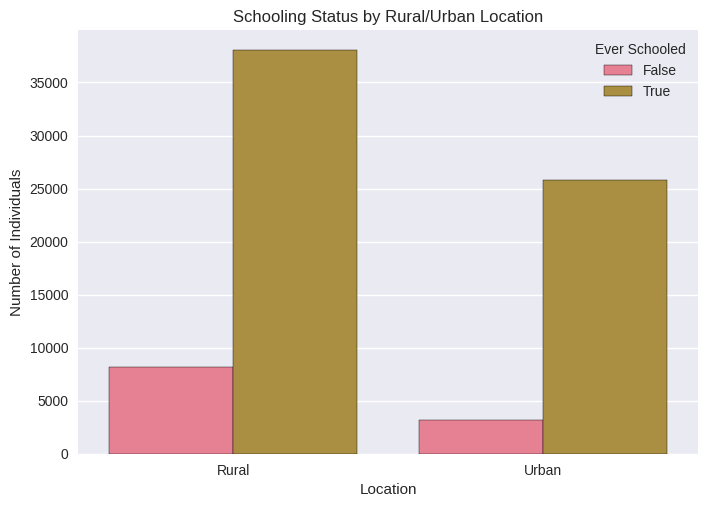

In [60]:
sns.countplot(
    data=person,
    x="rural_urban",
    hue="ever_schooled",
    edgecolor="black"
)
plt.title("Schooling Status by Rural/Urban Location")
plt.xlabel("Location")
plt.ylabel("Number of Individuals")
plt.legend(title="Ever Schooled")
plt.show()


This plot reveals  rural areas showing both higher absolute numbers of individuals who have never been schooled and a much higher proportion of unschooled individuals relative to their schooled population, suggesting more people surveyed in rural areas.

While rural areas have more total schooled individuals, the ratio of schooled to unschooled is considerably worse than in urban areas, indicating that rural location is a substantial barrier to educational access.

 This pattern reinforces rural-urban location as an important predictor variable for education outcomes, with rural residence being associated with significantly higher rates of never attending school.

# 3. Address

The goal is to model the probability that an individual has ever been schooled using both household-level and personal characteristics. This approach helps identify which socioeconomic and demographic factors are most strongly associated with school attendance.

Dependent variable (Y):

* ever_schooled (1 if Yes, 0 if No)

Independent variables (X):

* monthly_rent

* has_electricity
* rural_urban
* (head_education, age, gender..).

By fitting a logistic regression model with these predictors, the analysis aims to quantify the effect of each variable on the likelihood of schooling, while controlling for other factors.

The variable ever_schooled is converted from a categorical/boolean format into an integer (0 = No, 1 = Yes). This new column, ever_schooled_bin, serves as the dependent variable in the logistic regression model.

In [61]:
# Encode target
person["ever_schooled_bin"] = person["ever_schooled"].astype(int)

The independent variables (X) are created by encoding categorical features into dummy variables:

 one category is dropped to avoid multicollinearity (dummy variable trap).

The dependent variable (y) is set to ever_schooled_bin, representing whether an individual has ever attended school.

In [62]:
X = pd.get_dummies(person[["has_electricity", "rural_urban"]],
    drop_first=True  # avoid dummy trap
)

y = person["ever_schooled_bin"]

To ensure compatibility with statistical modeling libraries such as logistic regression both predictor and target variables are converted to float type.

In [63]:
X = X.astype(float)   # ensures numeric matrix
y = y.astype(float)

print(X.dtypes)
print(y.dtype)


has_electricity_Yes    float64
rural_urban_Urban      float64
dtype: object
float64


The dataset is split into training and testing subsets.The random_state is set to 42 , the answer to everything ꩜.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Finally we train a logistic model to predict whether an individual has ever been schooled.

In [65]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

print("Results")
print(classification_report(y_test, y_pred))


Results
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2266
         1.0       0.85      1.00      0.92     12765

    accuracy                           0.85     15031
   macro avg       0.42      0.50      0.46     15031
weighted avg       0.72      0.85      0.78     15031



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall accuracy is  85%, but that is misleading - it just reflects that the dataset is imbalanced (most people have been to school).
The model  predicts all 1s for ever_schooled, because that already gives it 85 percent accuracy.

To fix the imbalance we need to help the model focus on the minority class (never schooled).we can do so by introducing class weight balancing.

In [66]:
log_reg = LogisticRegression(max_iter=10000, class_weight="balanced")
log_reg.fit(X_train, y_train)
# Predictions
y_pred = log_reg.predict(X_test)

print("Results")
print(classification_report(y_test, y_pred))


Results
              precision    recall  f1-score   support

         0.0       0.22      0.71      0.34      2266
         1.0       0.91      0.55      0.69     12765

    accuracy                           0.58     15031
   macro avg       0.57      0.63      0.51     15031
weighted avg       0.81      0.58      0.64     15031




For the minority class (never schooled), it achieves high recall i.e. It catches 71% of those who never schooled which is an improvement but very low precision (22%), meaning it captures most actual cases but with many false positives.

 Conversely, for the majority class (ever schooled), it shows high precision 91% but poor recall 55%, indicating reliable predictions when it identifies this class but missing nearly half the actual cases.

 the accuracy Looks worse than before, but this is more honest because the model isn’t just defaulting to the majority.

  This pattern suggests the model is struggling with class separation rather than simply defaulting to the majority class, representing a more honest but challenging reality where correctly identifying the underrepresented "never schooled" group remains difficult despite catching most true case

In [67]:
print(len(person))

75155


### Adding county as a Feature

 drop_first=True removes one category per feature to avoid the dummy variable trap (perfect multicollinearity). for counties,it sets the county baseline as the first county which is Mombasa.

In [68]:
#X = pd.get_dummies(person[["county", "has_electricity", "rural_urban"]], drop_first=True)
X = pd.get_dummies(person[["county"]])
X = X.astype(float)   # ensures numeric matrix
y = y.astype(float)



To understand the relationship between these variables i will first use statsmodels

In [69]:
X = sm.add_constant(X).astype(float)   # add intercept
model = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.328605
         Iterations 7


The plot_odds_ratios function transforms logistic regression coefficients from statsmodels into more interpretable odds ratios.The plot shows which variables increase or decrease the odds of the outcome, with a red vertical line at 1 marking the “no effect” baseline. the odds ratios are displayed on a logarithmic scale.

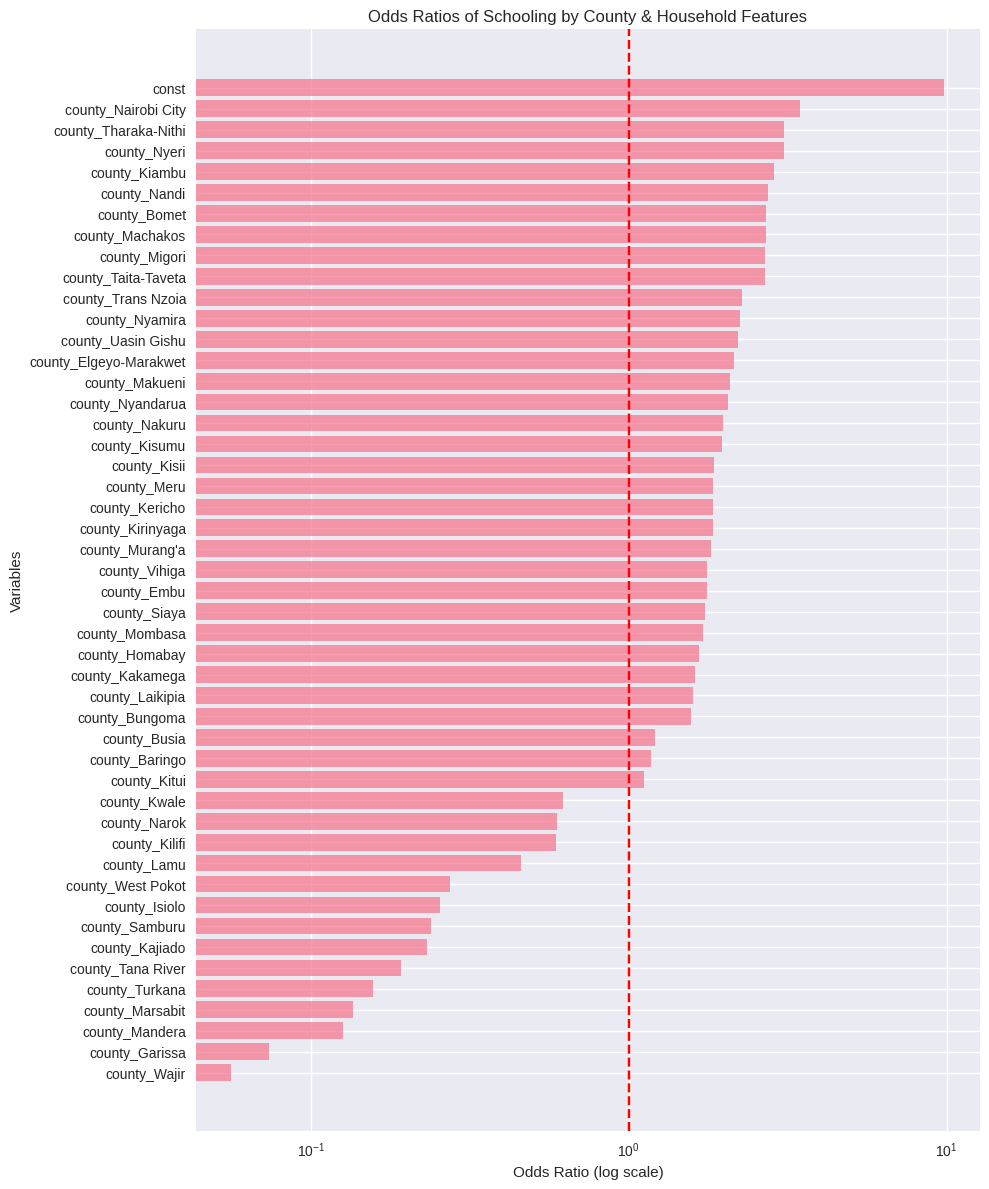

In [70]:
odds_ratios_df = address.plot_odds_ratios(model, title="Odds Ratios of Schooling by County & Household Features")


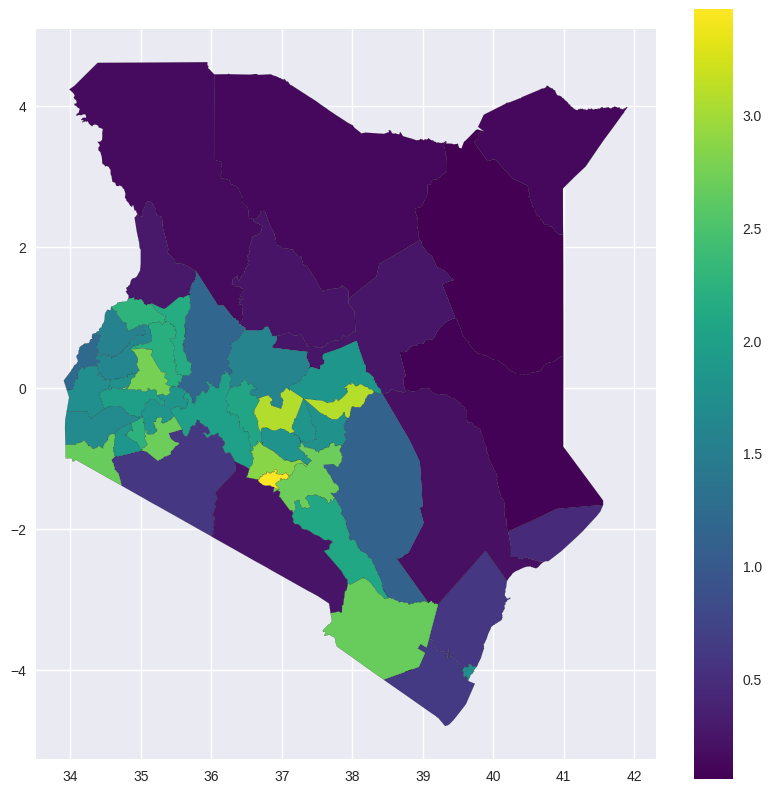

In [71]:
result = address.process_county_df(odds_ratios_df, access,county_list)
assess.plot_counties(relation_ids,result["OR"])


Now using a Logistic Model,

I introduced ROC-AUC which shows how well the model separates schooled vs. not schooled.

In [72]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

         0.0       0.38      0.72      0.50      2257
         1.0       0.94      0.79      0.86     12774

    accuracy                           0.78     15031
   macro avg       0.66      0.76      0.68     15031
weighted avg       0.86      0.78      0.80     15031

ROC-AUC: 0.799860535138007


The results show an improvement from the previous analysis though not satisfactory.The ROC-AUC of 0.82 suggests reasonable separability.